# Mission
- 제공된 타이타닉 데이터 사용
- passengerid 대비 생존율을 정확하게 맞출 수 있는 머신러닝 모델 완성
- submission 파일에 아래와 같이 저장하여 kaggle로 제출

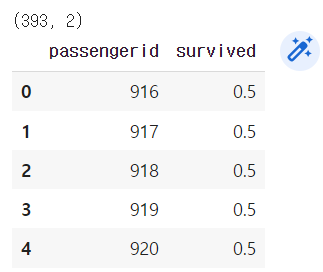

# Connect to google account

In [ ]:
from google.colab import drive
import pandas as pd

# 구글 드라이브 마운트
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 코렙 한글깨짐 방지
!apt -qq -y install fonts-nanum > /dev/null

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name() 
# fm._rebuild()  

%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)  
plt.rcParams['axes.unicode_minus'] = False

# Global Variables

In [ ]:
import easydict
import json
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/gdrive/My Drive/titanic_kaggle/data/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.submission_csv = args.default_path+'submission.csv'
args.save_results = args.default_path+"model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 42
SEED = 42
args.results = []

In [ ]:
# 데이터 시각화 라이브러리 
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 지난 결과 확인
# with open(args.save_results, 'r') as file:
#     args.results = json.load(file)

# args.results

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- Sex:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [ ]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [ ]:
ori_train.tail()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
911,911,0,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.4375,NaN,C
912,912,0,3,"Cacic, Mr. Jego Grga",male,18.0,0,0,315091,8.6625,NaN,S
913,913,0,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q
915,915,1,1,"Candee, Mrs. Edward (Helen Churchill Hungerford)",female,53.0,0,0,PC 17606,27.4458,NaN,C


In [ ]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    object 
 5   age          736 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   ticket       916 non-null    object 
 9   fare         916 non-null    float64
 10  cabin        198 non-null    object 
 11  embarked     915 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 86.0+ KB


In [ ]:
ori_train.describe(include = 'all')

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,916.000000,916.000000,916.000000,916,916,736.000000,916.000000,916.000000,916,916.000000,198,915
unique,NaN,NaN,NaN,915,2,NaN,NaN,NaN,703,NaN,146,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,2,589,NaN,NaN,NaN,7,NaN,4,645
mean,457.500000,0.377729,2.292576,NaN,NaN,29.698370,0.507642,0.361354,NaN,32.402710,NaN,NaN
std,264.570721,0.485084,0.838675,NaN,NaN,14.185627,1.044866,0.828054,NaN,50.506411,NaN,NaN
min,0.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,228.750000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,457.500000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.458300,NaN,NaN
75%,686.250000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.017700,NaN,NaN


In [ ]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

##drop_duplicates

In [ ]:
print(f'before : {ori_train.shape}')
ori_train.drop_duplicates(keep = 'first', inplace = True, ignore_index = True)
print(f'after : {ori_train.shape}')

before : (916, 12)
after : (916, 12)


# train_test_split

In [ ]:
# 피쳐와 타겟 데이터 분리
X = ori_train.drop('survived', axis = 1)
y = ori_train['survived'] #우리가 알고자하는 생존 데이터

In [ ]:
# 카테고리화
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.3, stratify =y , random_state = SEED)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 11), (275, 11), (641,), (275,))

# EDA

## Column Classification

In [ ]:
X_tr.describe(include = 'all')

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
count,641.000000,641.000000,641,641,523.000000,641.000000,641.000000,641,641.000000,138,641
unique,NaN,NaN,641,2,NaN,NaN,NaN,525,NaN,109,3
top,NaN,NaN,"Klaber, Mr. Herman",male,NaN,NaN,NaN,3101295,NaN,G6,S
freq,NaN,NaN,1,420,NaN,NaN,NaN,7,NaN,3,457
mean,462.230889,2.271451,NaN,NaN,29.853576,0.492980,0.324493,NaN,31.941796,NaN,NaN
std,265.479413,0.837376,NaN,NaN,14.536210,0.993902,0.742152,NaN,47.068732,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,230.000000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.925000,NaN,NaN
50%,468.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.500000,NaN,NaN
75%,692.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.000000,NaN,NaN


In [ ]:
X_tr['pclass'].nunique()

3

In [ ]:
X_tr['pclass'].unique()

array([1, 3, 2])

In [ ]:
X_tr['sibsp'].unique()

array([0, 2, 1, 3, 8, 4, 5])

In [ ]:
X_tr['cabin'].unique()

array(['C124', 'C32', nan, 'B52 B54 B56', 'B61', 'B94', 'C2', 'D43',
       'B78', 'B36', 'D11', 'F E69', 'B58 B60', 'C65', 'C132', 'D28',
       'E63', 'C80', 'E44', 'B39', 'A23', 'C116', 'C85', 'C106',
       'B57 B59 B63 B66', 'B45', 'E34', 'G6', 'B50', 'D50', 'F', 'C39',
       'C23 C25 C27', 'D49', 'F33', 'D35', 'D34', 'A18', 'C68', 'C54',
       'B77', 'E17', 'A5', 'E36', 'D20', 'E12', 'C101', 'C78', 'E39 E41',
       'F2', 'D38', 'B5', 'C93', 'E8', 'C95', 'E101', 'C22 C26', 'B20',
       'C7', 'C83', 'B51 B53 B55', 'B4', 'A6', 'C46', 'E121', 'A34',
       'C51', 'C92', 'B26', 'D15', 'C47', 'B96 B98', 'C53', 'B79', 'D7',
       'A10', 'E33', 'C123', 'C31', 'C87', 'C86', 'E46', 'E24', 'B49',
       'C55 C57', 'B73', 'C111', 'D17', 'A11', 'C148', 'E25', 'E58',
       'C62 C64', 'B80', 'D22', 'D36', 'E49', 'C89', 'E77', 'F G63',
       'C104', 'C91', 'A32', 'A24', 'A29', 'A20', 'B38', 'C130', 'B86',
       'B22'], dtype=object)

In [ ]:
X_tr['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [ ]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 539 to 636
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  641 non-null    int64  
 1   pclass       641 non-null    int64  
 2   name         641 non-null    object 
 3   gender       641 non-null    object 
 4   age          523 non-null    float64
 5   sibsp        641 non-null    int64  
 6   parch        641 non-null    int64  
 7   ticket       641 non-null    object 
 8   fare         641 non-null    float64
 9   cabin        138 non-null    object 
 10  embarked     641 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 60.1+ KB


In [ ]:
continous_cols = ['age', 'sibsp', 'parch', 'fare']
category_cols = ['pclass', 'gender', 'embarked']
other_cols = ['passengerid', 'name', 'ticket', 'cabin']

# ModelV0

## Missing Value

In [ ]:
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 11), (275, 11), (393, 11))

In [ ]:
train.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age            118
sibsp            0
parch            0
ticket           0
fare             0
cabin          503
embarked         0
dtype: int64

In [ ]:
test.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             62
sibsp            0
parch            0
ticket           0
fare             0
cabin          215
embarked         1
dtype: int64

In [ ]:
ori_te.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             1
cabin          296
embarked         1
dtype: int64

In [ ]:
embarked_mode = train['embarked'].mode().values[0]

test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)
test.isnull().sum(), ori_te.isnull().sum()

(passengerid      0
 pclass           0
 name             0
 gender           0
 age             62
 sibsp            0
 parch            0
 ticket           0
 fare             0
 cabin          215
 embarked         0
 dtype: int64, passengerid      0
 pclass           0
 name             0
 gender           0
 age             83
 sibsp            0
 parch            0
 ticket           0
 fare             1
 cabin          296
 embarked         0
 dtype: int64)

<AxesSubplot:ylabel='Frequency'>

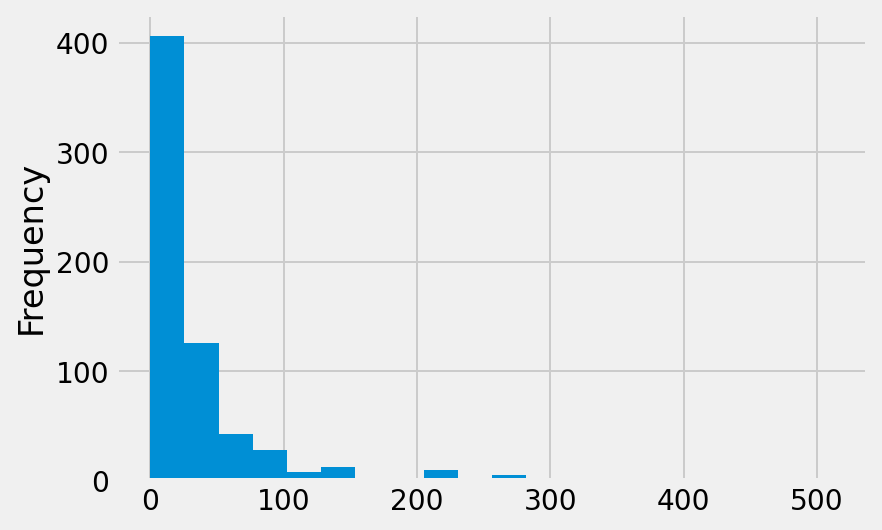

In [ ]:
train['fare'].plot.hist(bins = 20)

In [ ]:
fare_mode = train['fare'].median()

ori_te['fare'].fillna(fare_mode, inplace=True)
ori_te.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             0
cabin          296
embarked         0
dtype: int64

In [ ]:
(train['cabin'].isnull().sum() / train.shape[0]).round(4)

0.7847

In [ ]:
(test['cabin'].isnull().sum() / test.shape[0]).round(4)

0.7818

In [ ]:
(ori_te['cabin'].isnull().sum() / ori_te.shape[0]).round(4)

0.7532

In [ ]:
train.drop('cabin', axis = 1, inplace=True)
test.drop('cabin', axis = 1, inplace=True)
ori_te.drop('cabin', axis = 1, inplace=True)

train.isnull().sum(), test.isnull().sum(), ori_te.isnull().sum()

(passengerid      0
 pclass           0
 name             0
 gender           0
 age            118
 sibsp            0
 parch            0
 ticket           0
 fare             0
 embarked         0
 dtype: int64, passengerid     0
 pclass          0
 name            0
 gender          0
 age            62
 sibsp           0
 parch           0
 ticket          0
 fare            0
 embarked        0
 dtype: int64, passengerid     0
 pclass          0
 name            0
 gender          0
 age            83
 sibsp           0
 parch           0
 ticket          0
 fare            0
 embarked        0
 dtype: int64)

<AxesSubplot:ylabel='Frequency'>

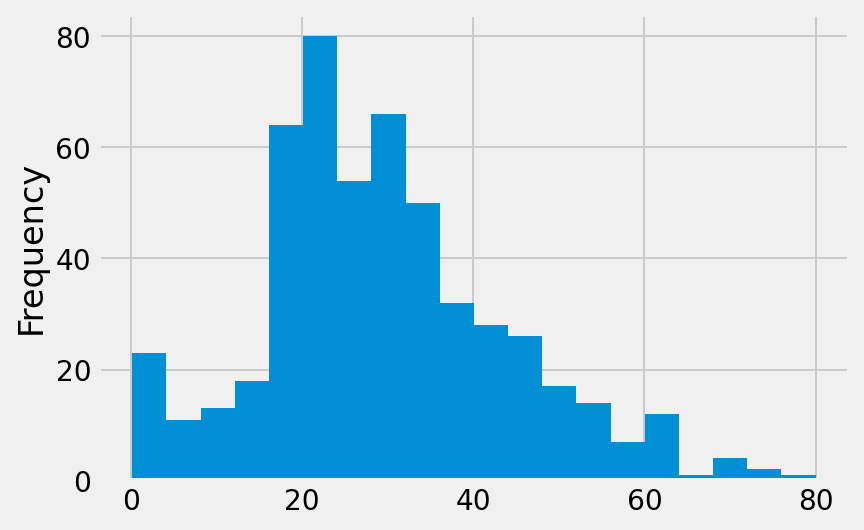

In [ ]:
train['age'].plot.hist(bins = 20)

In [ ]:
train['age_random'] = train['age']

random_sampling = (train['age'].dropna()).sample(train['age'].isnull().sum())
random_sampling.index = train[lambda x : x['age'].isnull()].index

train.loc[X_tr['age'].isnull(), 'age_random'] = random_sampling

#확인
train[['age', 'age_random']].isnull().sum()

age           118
age_random      0
dtype: int64

In [ ]:
test['age_random'] = test['age']

random_sampling = (test['age'].dropna()).sample(test['age'].isnull().sum())
random_sampling.index = test[lambda x : x['age'].isnull()].index

test.loc[test['age'].isnull(), 'age_random'] = random_sampling

#확인
test[['age', 'age_random']].isnull().sum()

age           62
age_random     0
dtype: int64

In [ ]:
ori_te['age_random'] = ori_te['age']

random_sampling = (ori_te['age'].dropna()).sample(ori_te['age'].isnull().sum())
random_sampling.index = ori_te[lambda x : x['age'].isnull()].index

ori_te.loc[ori_te['age'].isnull(), 'age_random'] = random_sampling

#확인
ori_te[['age', 'age_random']].isnull().sum()

age           83
age_random     0
dtype: int64

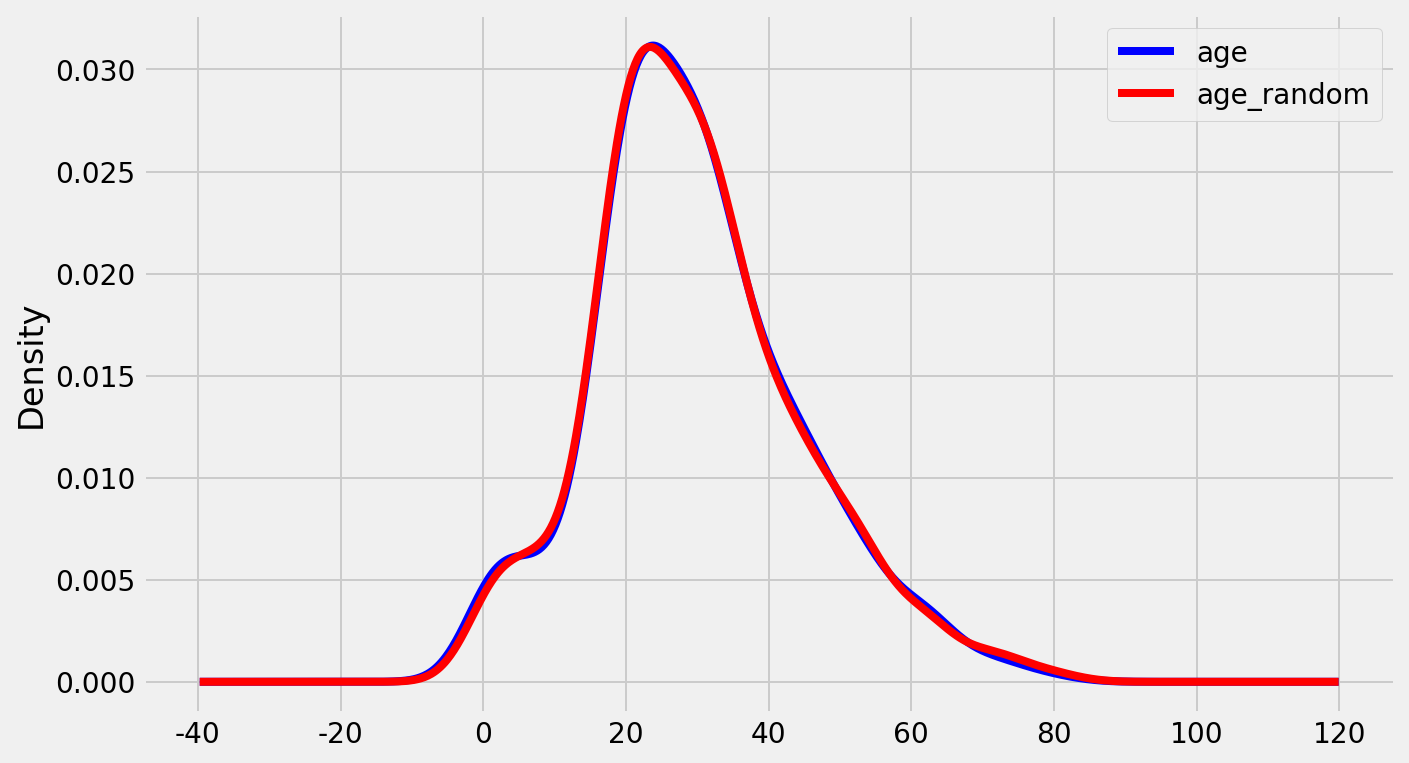

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

train['age'].plot(kind = 'kde', ax=ax, color='blue')
train['age_random'].plot(kind = 'kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc = 'best')

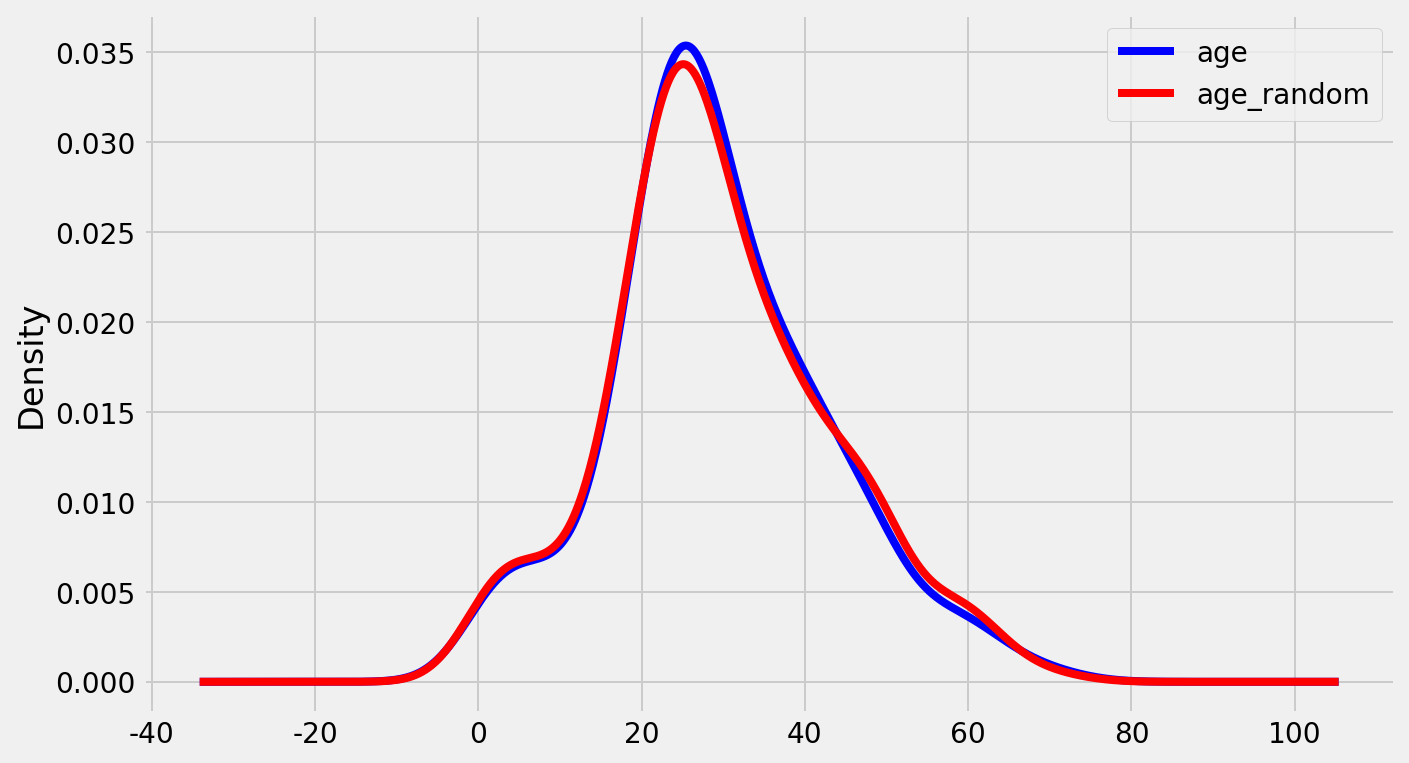

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

test['age'].plot(kind = 'kde', ax=ax, color='blue')
test['age_random'].plot(kind = 'kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc = 'best')

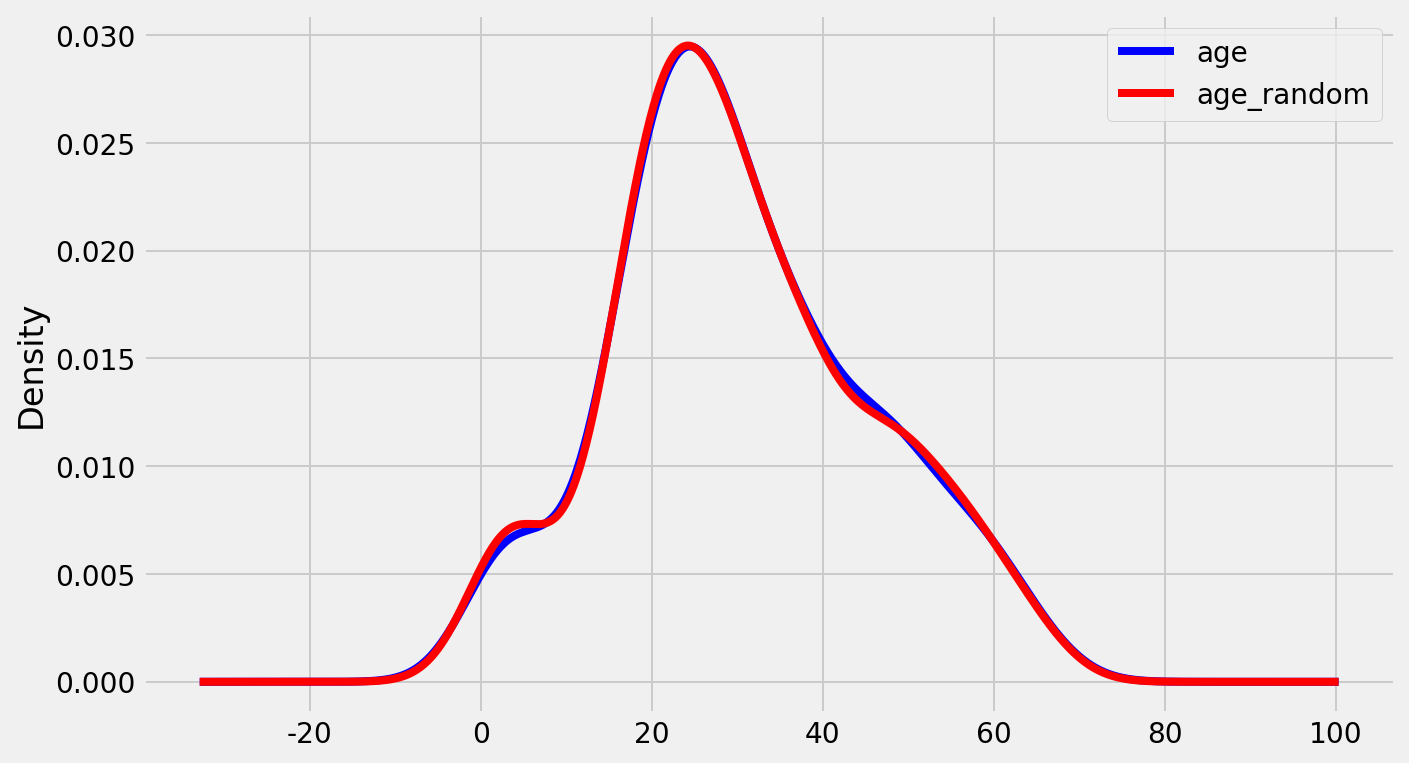

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ori_te['age'].plot(kind = 'kde', ax=ax, color='blue')
ori_te['age_random'].plot(kind = 'kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc = 'best')

In [ ]:
train.drop('age', axis = 1, inplace = True)
test.drop('age', axis = 1, inplace = True)
ori_te.drop('age', axis = 1, inplace = True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

## Scaling

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 539 to 636
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  641 non-null    int64  
 1   pclass       641 non-null    int64  
 2   name         641 non-null    object 
 3   gender       641 non-null    object 
 4   sibsp        641 non-null    int64  
 5   parch        641 non-null    int64  
 6   ticket       641 non-null    object 
 7   fare         641 non-null    float64
 8   embarked     641 non-null    object 
 9   age_random   641 non-null    float64
dtypes: float64(2), int64(4), object(4)
memory usage: 55.1+ KB


In [ ]:
train.select_dtypes(include = np.number)

,passengerid,pclass,sibsp,parch,fare,age_random
539,539,1,0,0,26.5500,20.0
339,339,1,0,0,135.6333,36.0
505,505,3,0,0,8.0500,22.0
492,492,3,2,0,8.6625,26.0
897,897,3,0,0,7.8792,25.0
...,...,...,...,...,...,...
538,538,3,0,0,9.3250,24.0
761,761,3,1,0,14.4542,15.0
879,879,3,0,2,24.1500,10.0
214,214,1,0,0,79.2000,24.0


In [ ]:
continous_cols = ['age_random', 'sibsp', 'parch', 'fare']

from sklearn.preprocessing import StandardScaler

std = StandardScaler()

train[continous_cols] = std.fit_transform(train[continous_cols])
test[continous_cols] = std.transform(test[continous_cols])
ori_te[continous_cols] = std.transform(ori_te[continous_cols])

train[continous_cols]

,age_random,sibsp,parch,fare
539,-0.680937,-0.496392,-0.437574,-0.114641
339,0.412756,-0.496392,-0.437574,2.204701
505,-0.544225,-0.496392,-0.437574,-0.507990
492,-0.270802,1.517451,-0.437574,-0.494967
897,-0.339158,-0.496392,-0.437574,-0.511622
...,...,...,...,...
538,-0.407514,-0.496392,-0.437574,-0.480881
761,-1.022716,0.510529,-0.437574,-0.371823
879,-1.364495,-0.496392,2.259396,-0.165670
214,-0.407514,-0.496392,-0.437574,1.004810


In [ ]:
train[continous_cols].shape, test[continous_cols].shape, ori_te[continous_cols].shape

((641, 4), (275, 4), (393, 4))

## Encoding

In [ ]:
pip install category_encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
category_cols = ['pclass', 'gender', 'embarked']

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names = True)
enco_tr = pd.DataFrame()
enco_te = pd.DataFrame()
enc_ori_te = pd.DataFrame()

for col in train[category_cols].columns:
  _enco = encoder.fit_transform(train[col].astype('category'))
  enco_tr = pd.concat([enco_tr, _enco], axis=1)

  _enco = encoder.transform(test[col].astype('category'))
  enco_te = pd.concat([enco_te, _enco], axis=1)
  
  _enco = encoder.transform(ori_te[col].astype('category'))
  enc_ori_te = pd.concat([enc_ori_te, _enco], axis=1)

In [ ]:
enco_tr.shape, enco_te.shape, enc_ori_te.shape

((641, 8), (275, 8), (393, 8))

In [ ]:
train.head()

,passengerid,pclass,name,gender,sibsp,parch,ticket,fare,embarked,age_random
539,539,1,"Klaber, Mr. Herman",male,-0.496392,-0.437574,113028,-0.114641,S,-0.680937
339,339,1,"Young, Miss. Marie Grice",female,-0.496392,-0.437574,PC 17760,2.204701,C,0.412756
505,505,3,"Davies, Mr. Evan",male,-0.496392,-0.437574,SC/A4 23568,-0.507990,S,-0.544225
492,492,3,"Kink, Mr. Vincenz",male,1.517451,-0.437574,315151,-0.494967,S,-0.270802
897,897,3,"Linehan, Mr. Michael",male,-0.496392,-0.437574,330971,-0.511622,Q,-0.339158


## Training

In [ ]:
tr = pd.concat([train[continous_cols], enco_tr], axis=1)
te = pd.concat([test[continous_cols], enco_te], axis=1)
ori = pd.concat([ori_te[continous_cols], enc_ori_te], axis=1)

tr.shape, te.shape,  ori.shape

((641, 12), (275, 12), (393, 12))

In [ ]:
tr.head()

,age_random,sibsp,parch,fare,pclass_1.0,pclass_3.0,pclass_2.0,gender_male,gender_female,embarked_S,embarked_C,embarked_Q
539,-0.680937,-0.496392,-0.437574,-0.114641,1,0,0,1,0,1,0,0
339,0.412756,-0.496392,-0.437574,2.204701,1,0,0,0,1,0,1,0
505,-0.544225,-0.496392,-0.437574,-0.507990,0,1,0,1,0,1,0,0
492,-0.270802,1.517451,-0.437574,-0.494967,0,1,0,1,0,1,0,0
897,-0.339158,-0.496392,-0.437574,-0.511622,0,1,0,1,0,0,0,1


In [ ]:
tr.isnull().sum().sum(), te.isnull().sum().sum(), ori.isnull().sum().sum()

(0, 0, 0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelV0 = DecisionTreeClassifier(random_state=args.random_state)

print(f'{tr.shape} / {y_tr.shape}')
modelV0.fit(tr, y_tr)

(641, 12) / (641,)


DecisionTreeClassifier(random_state=42)

## Evaluation

In [ ]:
score_tr = modelV0.score(tr, y_tr)
score_te = modelV0.score(te, y_te) 

score_tr, score_te  

(0.9906396255850234, 0.7927272727272727)

In [ ]:
from sklearn.metrics import roc_curve, auc 

y_pred = modelV0.predict_proba(te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.7887145748987854


In [ ]:
ori_te_pred = modelV0.predict_proba(ori)[:,1]
ori_te_pred.shape

(393,)

In [ ]:
df_feature_importances = pd.DataFrame(modelV0.feature_importances_, tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(12, 2)


,index,0
0,gender_male,0.531790
1,age_random,0.187646
2,fare,0.180041
3,sibsp,0.029246
4,pclass_3.0,0.026901
5,parch,0.018720
6,embarked_C,0.009211
7,pclass_2.0,0.006297
8,embarked_Q,0.005901
9,embarked_S,0.004247


In [ ]:
args.results.append(
    {
        'model': 'modelV0',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0227'
    }
)

args.results

[{'model': 'modelV0',
  'score_tr': 0.9906396255850234,
  'score_te': 0.7927272727272727,
  'auc_te': 0.7887145748987854,
  'ori_te_pred': array([1.        , 1.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 1.        , 0.        , 1.        ,
         1.        , 0.        , 0.        , 0.        , 1.        ,
         1.        , 1.        , 1.

# ModelV1

- ModelV0 결과
  - score 82점 획득
  - 지속적인 Version Upgrade를 통한 score 상승 필요
- feature_importances의 상위 5개
  - gender_male :	0.532091
  - age_random : 	0.204676
  - fare	: 0.176452
  - pclass_3.0 : 0.025995
  - sibsp	: 0.024247
- 인사이트
  - feature_importances의 결과 성별을 가장 많이 학습한 것으로 보임
  - 더 높은 score 달성을 위해 다른 유의미한 Feature Extraction가 필요할 것으로 보임
  - 무의미한 Feature 제거 해보는 작업도 방법
  - **ModelV1에서는 Feature Extraction을 중점적으로 진행**
- 가설
  - 가장 많은 학습을 달성한 gender_male이 50%인 반면 gender_female는 거의 학습하지 않은 관계로 이를 보완한 Feature 생성은 score에 도움을 줄 수 있을 것이다.
  - gender 이외에 학습이 되지 못한 다른 유의미한 패턴을 찾고 이를 통한 Feature Extraction은 score 상승에 도움이 될 것이다.

## Feature Extraction

In [ ]:
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 11), (275, 11), (393, 11))

In [ ]:
train.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age            118
sibsp            0
parch            0
ticket           0
fare             0
cabin          503
embarked         0
dtype: int64

In [ ]:
train.head()

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
539,539,1,"Klaber, Mr. Herman",male,NaN,0,0,113028,26.5500,C124,S
339,339,1,"Young, Miss. Marie Grice",female,36.0,0,0,PC 17760,135.6333,C32,C
505,505,3,"Davies, Mr. Evan",male,22.0,0,0,SC/A4 23568,8.0500,NaN,S
492,492,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S
897,897,3,"Linehan, Mr. Michael",male,NaN,0,0,330971,7.8792,NaN,Q


In [ ]:
cols = ['age', 'gender', 'fare', 'pclass', 'sibsp', 'parch', 'embarked']
survived = pd.DataFrame(y_tr)

data = pd.concat([train[cols], survived], axis = 1)
data

,age,gender,fare,pclass,sibsp,parch,embarked,survived
539,NaN,male,26.5500,1,0,0,S,0
339,36.0,female,135.6333,1,0,0,C,1
505,22.0,male,8.0500,3,0,0,S,0
492,26.0,male,8.6625,3,2,0,S,0
897,NaN,male,7.8792,3,0,0,Q,0
...,...,...,...,...,...,...,...,...
538,24.0,male,9.3250,3,0,0,S,0
761,15.0,female,14.4542,3,1,0,C,1
879,10.0,female,24.1500,3,0,2,S,0
214,24.0,male,79.2000,1,0,0,C,0


In [ ]:
data.corr()

,age,fare,pclass,sibsp,parch,survived
age,1.000000,0.151860,-0.442647,-0.234970,-0.195589,-0.040994
fare,0.151860,1.000000,-0.555652,0.161138,0.189171,0.176041
pclass,-0.442647,-0.555652,1.000000,0.077389,0.071752,-0.214195
sibsp,-0.234970,0.161138,0.077389,1.000000,0.399212,0.015226
parch,-0.195589,0.189171,0.071752,0.399212,1.000000,0.075825
survived,-0.040994,0.176041,-0.214195,0.015226,0.075825,1.000000


### category_cols
- category_cols = ['pclass', 'gender', 'embarked']

> Pclass (1=1등석, 2=2등석, 3=3등석)

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

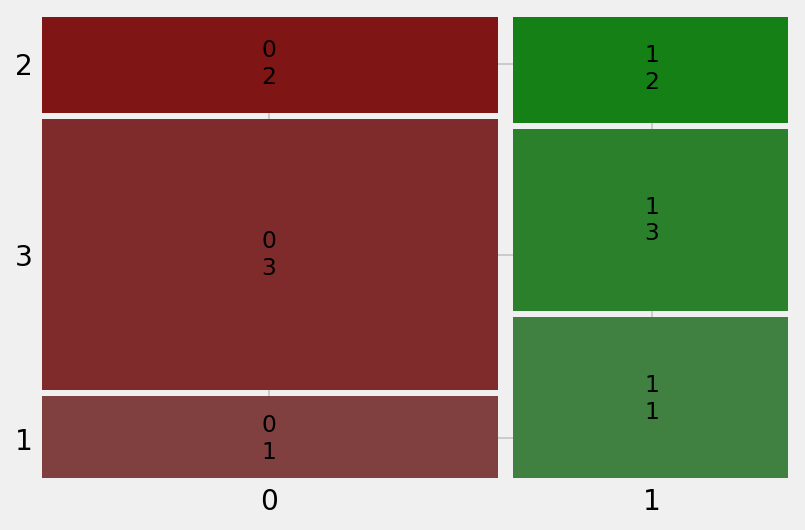

In [ ]:
mosaic(data, ['survived', 'pclass'], gap = 0.02)
plt.show()

In [ ]:
data['pclass'].value_counts()

3    335
1    161
2    145
Name: pclass, dtype: int64

In [ ]:
pd.crosstab(data['pclass'], data['survived'], margins = True, normalize = 'all')

survived,0,1,All
pclass,,,
1,0.115445,0.135725,0.251170
2,0.135725,0.090484,0.226209
3,0.371295,0.151326,0.522621
All,0.622465,0.377535,1.000000


- pcalss가 높은 숫자일수록 생존율이 낮아짐
- pclass 1이 높은 유독 생존율을 보임

add pcalss feature

In [ ]:
pcalss_pivot = pd.pivot_table(data, 
                     index = 'pclass', 
                     columns = ['gender'], 
                     values = 'survived',  
                     aggfunc = ['mean']) 

pcalss_pivot

mean          
gender    female      male
pclass                    
1       1.000000  0.229167
2       0.927273  0.077778
3       0.732673  0.098291

In [ ]:
data['gender_pclass'] = data.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

data['gender_pclass'].unique()

array(['male_1', 'female_1', 'male_3', 'male_2', 'female_3', 'female_2'],
      dtype=object)

In [ ]:
data['gender_age'] = data.apply(lambda row: row['gender']+'_'+str(row['age_']), axis=1)

data['gender_age'].unique()

KeyError: ignored

> Embarked (탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴)

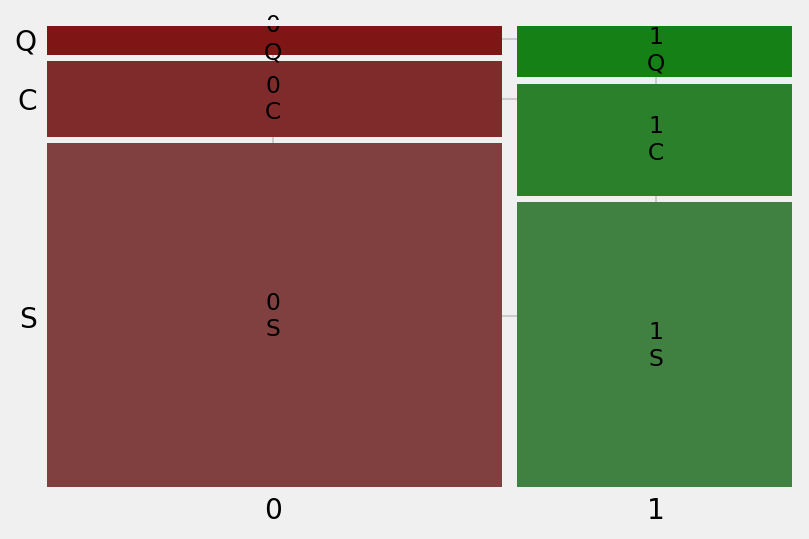

In [ ]:
mosaic(data, ['survived', 'embarked'], gap = 0.02)
plt.show()

In [ ]:
data['embarked'].value_counts()

S    457
C    127
Q     57
Name: embarked, dtype: int64

In [ ]:
pd.crosstab(data['embarked'], data['survived'], margins = True, normalize = 'all')

survived,0,1,All
embarked,,,
C,0.104524,0.093604,0.198128
Q,0.043682,0.045242,0.088924
S,0.474259,0.238690,0.712949
All,0.622465,0.377535,1.000000


- C, Q의 경우 생존율이 비슷
- S의 경우 유독 생존율이 낮음

add gender embarked

In [ ]:
embarked_pivot = pd.pivot_table(data, 
                     index = 'embarked', 
                     columns = 'gender', 
                     values = 'survived',  
                     aggfunc = ['mean', 'sum']) 

embarked_pivot

mean              sum     
gender      female      male female male
embarked                                
C         0.937500  0.189873     45   15
Q         0.965517  0.035714     28    1
S         0.812500  0.115016    117   36

In [ ]:
data['gender_embarked'] = data.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)

data['gender_embarked'].unique()

array(['male_S', 'female_C', 'male_Q', 'female_S', 'male_C', 'female_Q'],
      dtype=object)

In [ ]:
data.columns

Index(['age', 'gender', 'fare', 'pclass', 'sibsp', 'parch', 'embarked',
       'survived', 'gender_pclass', 'gender_embarked'],
      dtype='object')

> Gender (male=남성, female=여성)

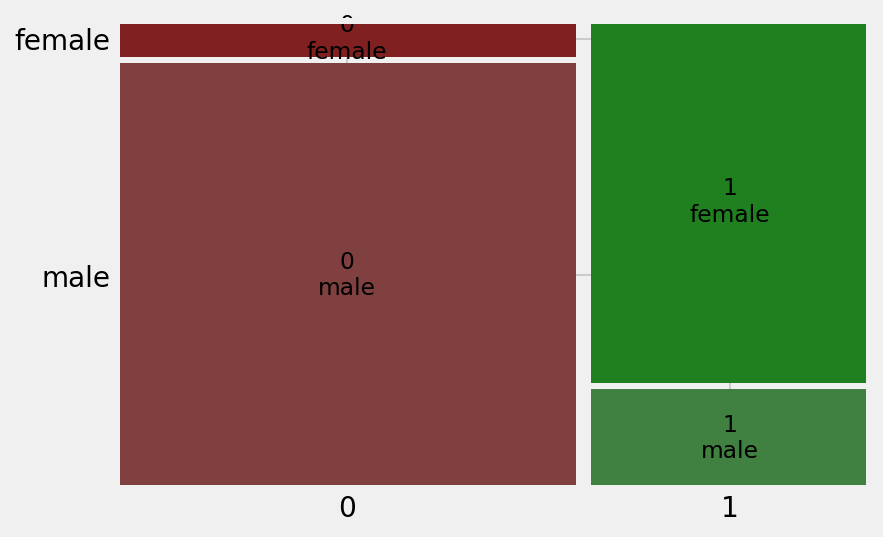

In [ ]:
mosaic(data, ['survived', 'gender'], gap = 0.02)
plt.show()

In [ ]:
data['gender'].value_counts()

male      420
female    221
Name: gender, dtype: int64

In [ ]:
pd.crosstab(data['gender'], data['survived'], margins = True, normalize = 'index')

survived,0,1
gender,,
female,0.140271,0.859729
male,0.876190,0.123810
All,0.622465,0.377535


- 남성 수가 여성의 약 2배
- 남자보다 **여자가 생존확률이 확연히 높음**

### continous_cols
- continous_cols = ['age', 'sibsp', 'parch', 'fare']

In [ ]:
data.corr()

,age,fare,pclass,sibsp,parch,survived
age,1.000000,0.151860,-0.442647,-0.234970,-0.195589,-0.040994
fare,0.151860,1.000000,-0.555652,0.161138,0.189171,0.176041
pclass,-0.442647,-0.555652,1.000000,0.077389,0.071752,-0.214195
sibsp,-0.234970,0.161138,0.077389,1.000000,0.399212,0.015226
parch,-0.195589,0.189171,0.071752,0.399212,1.000000,0.075825
survived,-0.040994,0.176041,-0.214195,0.015226,0.075825,1.000000


> Age

<AxesSubplot:ylabel='Frequency'>

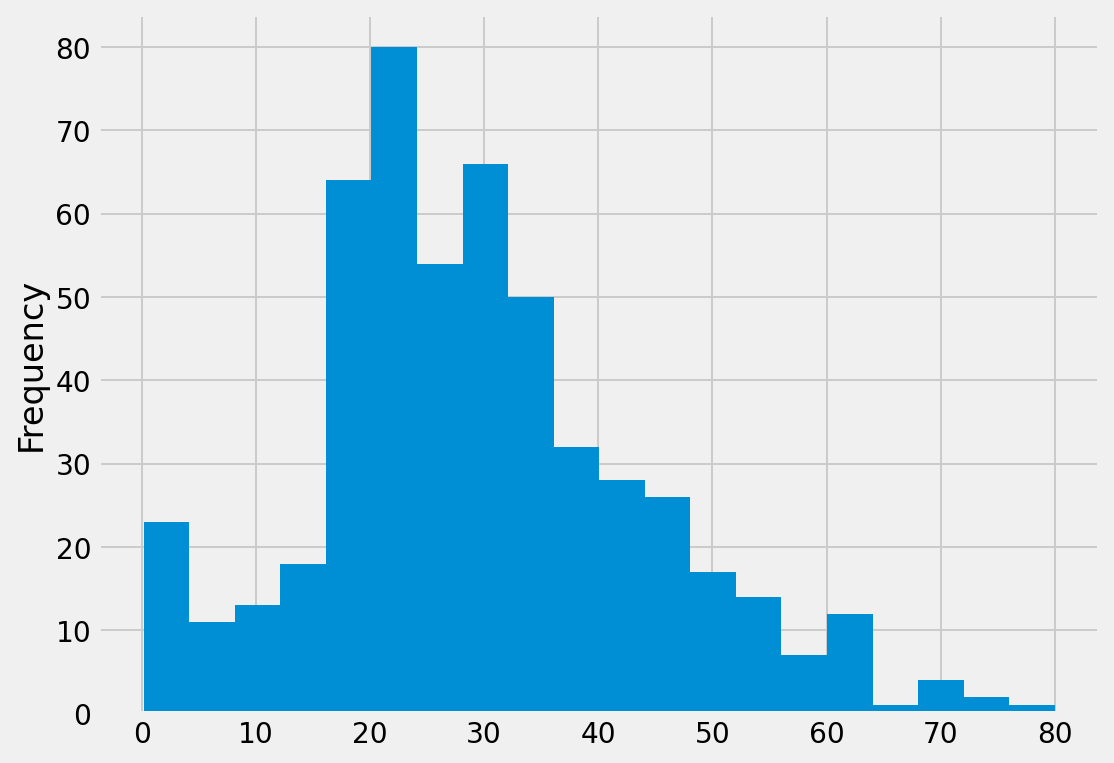

In [ ]:
Afig, ax = plt.subplots(figsize = (8, 6))
data['age'].plot.hist(bins = 20)

In [ ]:
data["age_"] = data["age"].map(lambda x: x // 10)
data.head()

,age,gender,fare,pclass,sibsp,parch,embarked,survived,gender_pclass,gender_embarked,age_
539,NaN,male,26.5500,1,0,0,S,0,male_1,male_S,NaN
339,36.0,female,135.6333,1,0,0,C,1,female_1,female_C,3.0
505,22.0,male,8.0500,3,0,0,S,0,male_3,male_S,2.0
492,26.0,male,8.6625,3,2,0,S,0,male_3,male_S,2.0
897,NaN,male,7.8792,3,0,0,Q,0,male_3,male_Q,NaN


In [ ]:
data.age_.value_counts()

2.0    161
3.0    126
1.0     77
4.0     65
0.0     40
5.0     32
6.0     15
7.0      6
8.0      1
Name: age_, dtype: int64

In [ ]:
pd.crosstab(data['age_'], data['survived'], margins = True, normalize = 'all')

survived,0,1,All
age_,,,
0.0,0.038241,0.038241,0.076482
1.0,0.087954,0.059273,0.147228
2.0,0.202677,0.105163,0.307839
3.0,0.131931,0.108987,0.240918
4.0,0.087954,0.036329,0.124283
5.0,0.034417,0.026769,0.061185
6.0,0.017208,0.011472,0.028681
7.0,0.009560,0.001912,0.011472
8.0,0.000000,0.001912,0.001912


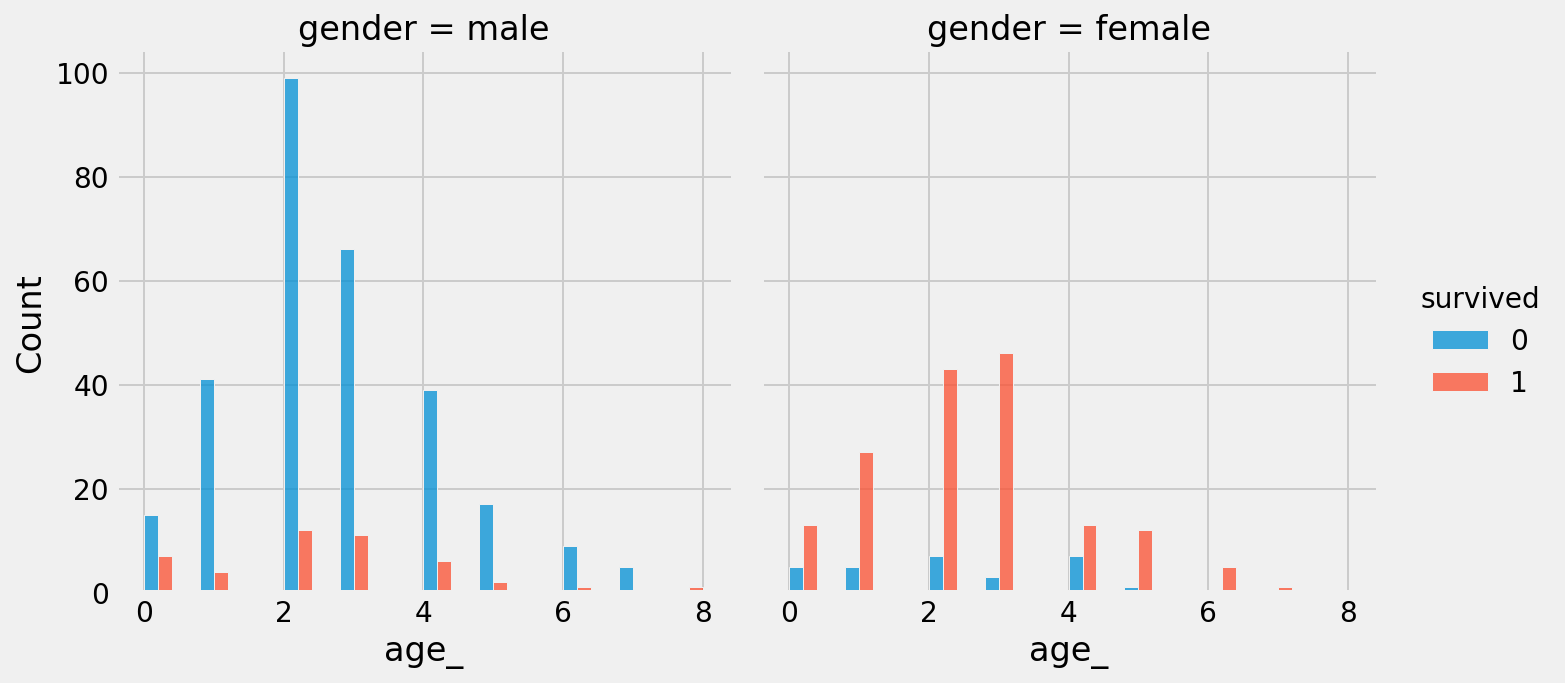

In [ ]:
sns.displot(data, x="age_", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
age_pivot = pd.pivot_table(data,             
                     index = 'age_',
                     columns = 'gender',
                     values = 'survived', 
                     aggfunc = ['mean', 'sum'])

age_pivot

mean              sum      
gender    female      male female  male
age_                                   
0.0     0.722222  0.318182   13.0   7.0
1.0     0.843750  0.088889   27.0   4.0
2.0     0.860000  0.108108   43.0  12.0
3.0     0.938776  0.142857   46.0  11.0
4.0     0.650000  0.133333   13.0   6.0
5.0     0.923077  0.105263   12.0   2.0
6.0     1.000000  0.100000    5.0   1.0
7.0     1.000000  0.000000    1.0   0.0
8.0          NaN  1.000000    NaN   1.0

In [ ]:
data['gender'].value_counts()

male      420
female    221
Name: gender, dtype: int64

- 20대, 40대의 사망률이  확인
- 그 중에서도 남성의 죽음이 많은 것으로 확인이 되었다.
- age와 gender는 생존 여부에 관계가 있는 것으로 판단
  - 남자의 경우 영유아를 제외한 모든 연령대에서 낮은 생존률을 보임
- **연령대는 의미 있는 피쳐로 확인**

In [ ]:
data.head()

,age,gender,fare,pclass,sibsp,parch,embarked,survived,gender_pclass,gender_embarked,age_
539,NaN,male,26.5500,1,0,0,S,0,male_1,male_S,NaN
339,36.0,female,135.6333,1,0,0,C,1,female_1,female_C,3.0
505,22.0,male,8.0500,3,0,0,S,0,male_3,male_S,2.0
492,26.0,male,8.6625,3,2,0,S,0,male_3,male_S,2.0
897,NaN,male,7.8792,3,0,0,Q,0,male_3,male_Q,NaN


- Feature Extraction age

In [ ]:
data[['age_', 'gender']]

,age_,gender
539,NaN,male
339,3.0,female
505,2.0,male
492,2.0,male
897,NaN,male
...,...,...
538,2.0,male
761,1.0,female
879,1.0,female
214,2.0,male


> Sibsp (타이타닉 호에 동승한 자매/배우자의 수)

In [ ]:
data['sibsp'].value_counts()

0    438
1    150
2     24
3     12
4     12
8      3
5      2
Name: sibsp, dtype: int64

<AxesSubplot:ylabel='Frequency'>

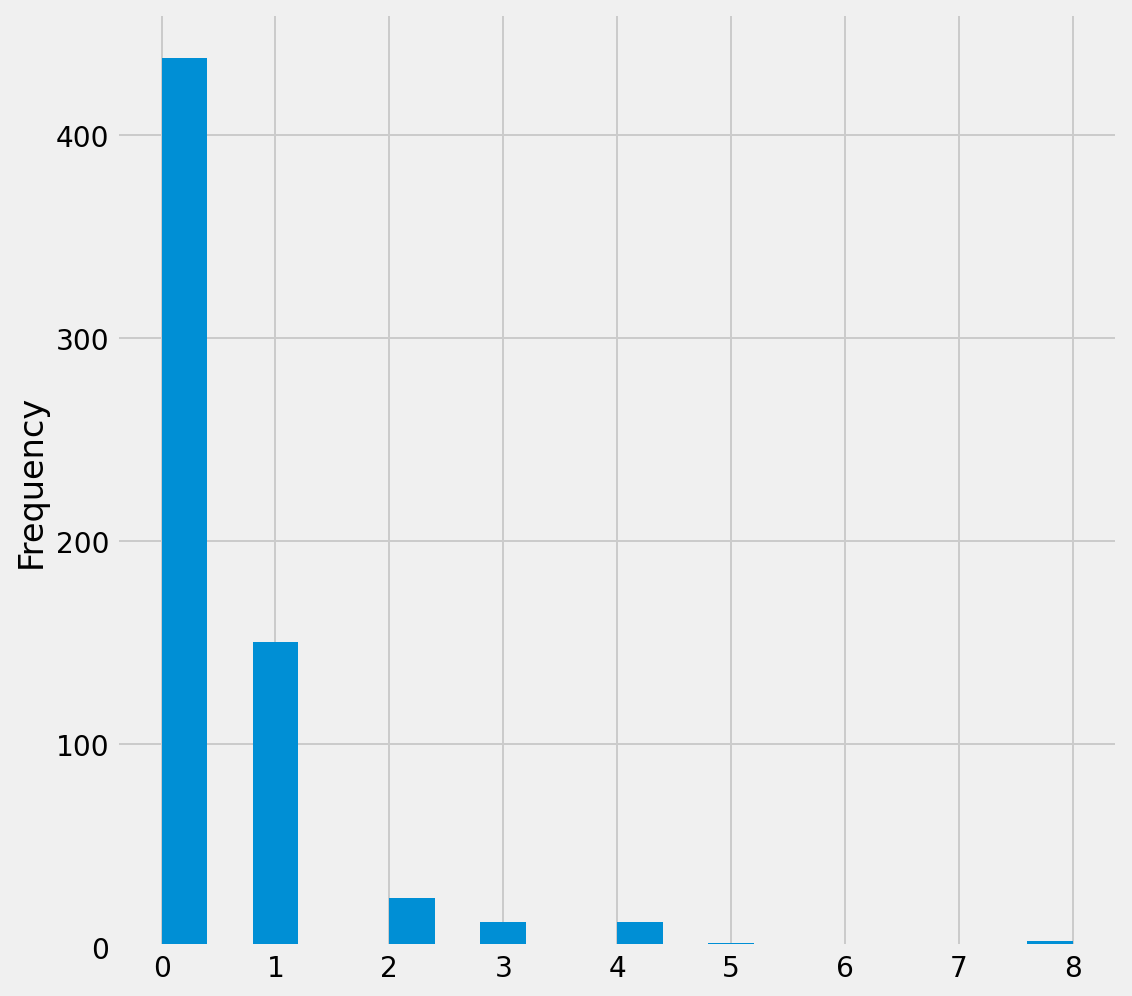

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))
data['sibsp'].plot.hist(bins = 20)

In [ ]:
pd.crosstab(data['sibsp'], data['survived'], margins = True, normalize = 'all')

survived,0,1,All
sibsp,,,
0,0.458658,0.224649,0.683307
1,0.104524,0.129485,0.234009
2,0.021841,0.015601,0.037441
3,0.014041,0.004680,0.018721
4,0.017161,0.001560,0.018721
5,0.003120,0.000000,0.003120
8,0.003120,0.001560,0.004680
All,0.622465,0.377535,1.000000


In [ ]:
sibsp_pivot = pd.pivot_table(data,             
                     index = 'sibsp',
                     columns = 'gender',
                     values = 'survived', 
                     aggfunc = ['mean', 'sum'])

sibsp_pivot

mean              sum      
gender    female      male female  male
sibsp                                  
0       0.879032  0.111465  109.0  35.0
1       0.880000  0.226667   66.0  17.0
2       0.909091  0.000000   10.0   0.0
3       0.500000  0.000000    3.0   0.0
4       0.250000  0.000000    1.0   0.0
5            NaN  0.000000    NaN   0.0
8       1.000000  0.000000    1.0   0.0

In [ ]:
sibsp_pivot = pd.pivot_table(data,             
                     index = 'sibsp',
                     columns = 'gender',
                     aggfunc = ['sum'])

sibsp_pivot

sum                                                            \
            age            age_              fare             parch         
gender   female     male female   male     female       male female  male   
sibsp                                                                       
0       2971.00  7610.16  256.0  656.0  4354.8001  6526.1244   42.0  19.0   
1       2086.17  2116.09  179.0  184.0  3546.3790  3839.0459   46.0  52.0   
2        202.50   333.00   17.0   27.0   253.8666   482.5875    7.0   2.0   
3         89.00    89.00    8.0    6.0   378.6834   377.4667    6.0   7.0   
4         31.00    61.00    1.0    2.0   125.2125   288.0750    8.0   9.0   
5           NaN    10.00    NaN    0.0        NaN    93.8000    NaN   4.0   
8          0.00    14.50    0.0    1.0    69.5500   139.1000    2.0   4.0   

                                     
       pclass        survived        
gender female   male   female  male  
sibsp                                
0       271.0  742.0    109.0  35.0  
1       150.0  152.0     66.0  17.0  
2        27.0   32.0     10.0   0.0  
3        15.0   16.0      3.0   0.0  
4        12.0   24.0      1.0   0.0  
5         NaN    6.0      NaN   0.0  
8         3.0    6.0      1.0   0.0

- 2~3명이 함께 탑승한 경우 생존율이 높음
- ** sibsp = 2(동승자3명) 부터는 여자만 생존


> Parch (타이타닉 호에 동승한 부모/자식의 수)

In [ ]:
data['parch'].value_counts()

0    504
1     86
2     41
3      4
4      3
5      2
6      1
Name: parch, dtype: int64

<AxesSubplot:ylabel='Frequency'>

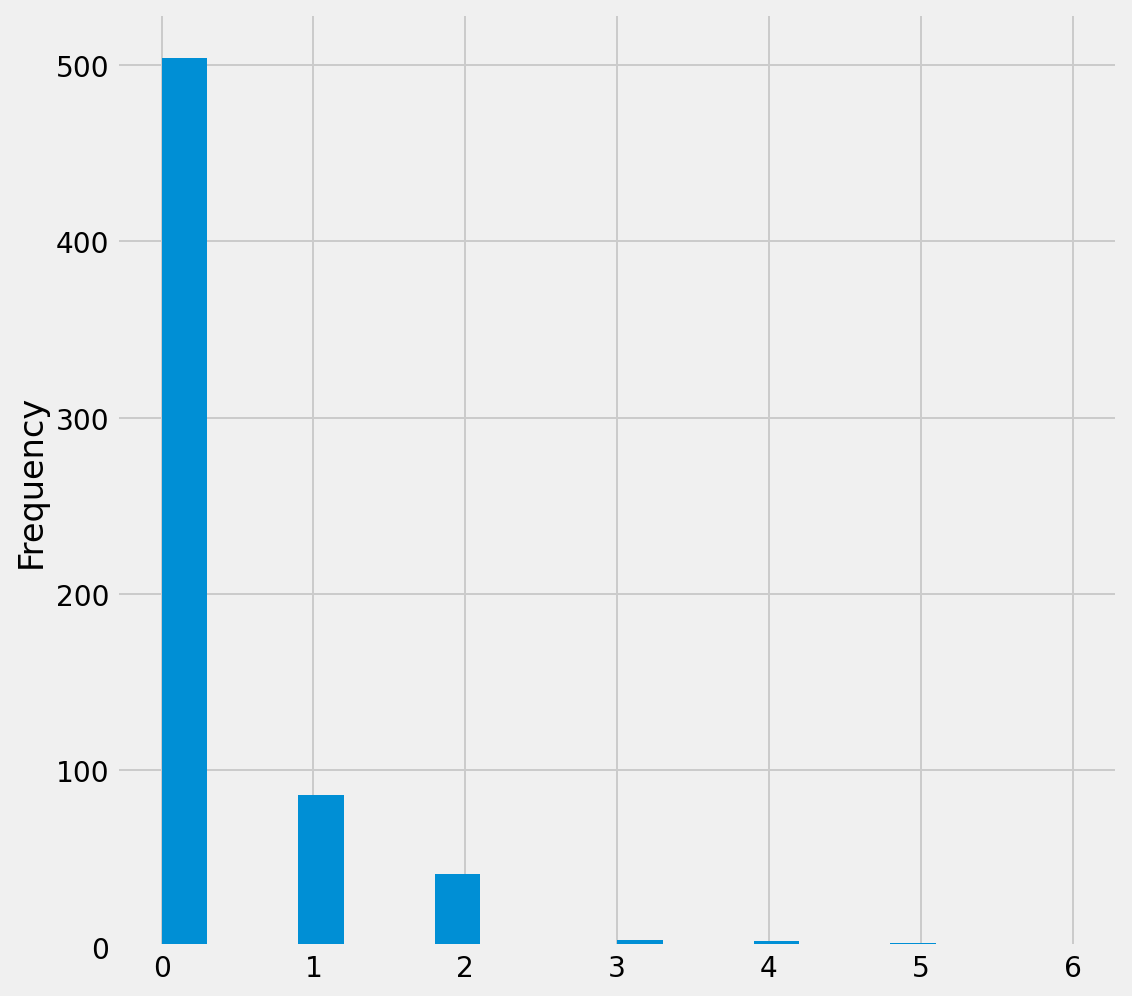

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))
data['parch'].plot.hist(bins = 20)

In [ ]:
pd.crosstab(data['parch'], data['survived'], margins = True, normalize = 'all')

survived,0,1,All
parch,,,
0,0.511700,0.274571,0.786271
1,0.067083,0.067083,0.134165
2,0.034321,0.029641,0.063963
3,0.003120,0.003120,0.006240
4,0.003120,0.001560,0.004680
5,0.001560,0.001560,0.003120
6,0.001560,0.000000,0.001560
All,0.622465,0.377535,1.000000


In [ ]:
parch_pivot = pd.pivot_table(data,             
                     index = 'parch',
                     columns = 'gender',
                     values = 'survived', 
                     aggfunc = ['mean', 'sum'])

parch_pivot

mean              sum      
gender    female      male female  male
parch                                  
0       0.906667  0.112994  136.0  40.0
1       0.813953  0.186047   35.0   8.0
2       0.681818  0.210526   15.0   4.0
3       1.000000  0.000000    2.0   0.0
4       0.500000  0.000000    1.0   0.0
5       0.500000       NaN    1.0   NaN
6            NaN  0.000000    NaN   0.0

- 1명 이상 같이 온 경우 확연히 생존율이 높게 나타남
  - 그 중에서도 가족단위의 여성의 생존율은 높게 나타났고
  - 남성의 생존율은 확연히 낮게 나타났다.

add parch_famliy

- Parch 0 : solo
- parch 1 : couple
- Parch 2~3 : family
- Parch 4~ : big family


In [ ]:
p1 = data['parch'] == 0
data['parch_solo'] = p1

p2 = data['parch'] == 1
data['parch_couple'] = p2

p3 = data['parch'] == 2 
p4 = data['parch'] == 3
p = p3 | p4
data['parch_family'] = p

p5 = data['parch'] >= 4
data['parch_big'] = p5

data.head()

,age,gender,fare,pclass,sibsp,parch,embarked,survived,gender_pclass,gender_embarked,age_,parch_solo,parch_couple,parch_family,parch_big
539,NaN,male,26.5500,1,0,0,S,0,male_1,male_S,NaN,True,False,False,False
339,36.0,female,135.6333,1,0,0,C,1,female_1,female_C,3.0,True,False,False,False
505,22.0,male,8.0500,3,0,0,S,0,male_3,male_S,2.0,True,False,False,False
492,26.0,male,8.6625,3,2,0,S,0,male_3,male_S,2.0,True,False,False,False
897,NaN,male,7.8792,3,0,0,Q,0,male_3,male_Q,NaN,True,False,False,False


In [ ]:
data['parch'].unique()

array([0, 4, 2, 3, 1, 6, 5])

In [ ]:
data.shape

(641, 15)

In [ ]:
data[['parch_solo', 'parch_family', 'parch_big', 'parch_couple']].astype("int32")

,parch_solo,parch_family,parch_big,parch_couple
539,1,0,0,0
339,1,0,0,0
505,1,0,0,0
492,1,0,0,0
897,1,0,0,0
...,...,...,...,...
538,1,0,0,0
761,1,0,0,0
879,0,1,0,0
214,1,0,0,0


> fare : 승객 요금

In [ ]:
data['fare'].describe()

count    641.000000
mean      31.941796
std       47.068732
min        0.000000
25%        7.925000
50%       14.500000
75%       30.000000
max      512.329200
Name: fare, dtype: float64

<AxesSubplot:xlabel='survived', ylabel='fare'>

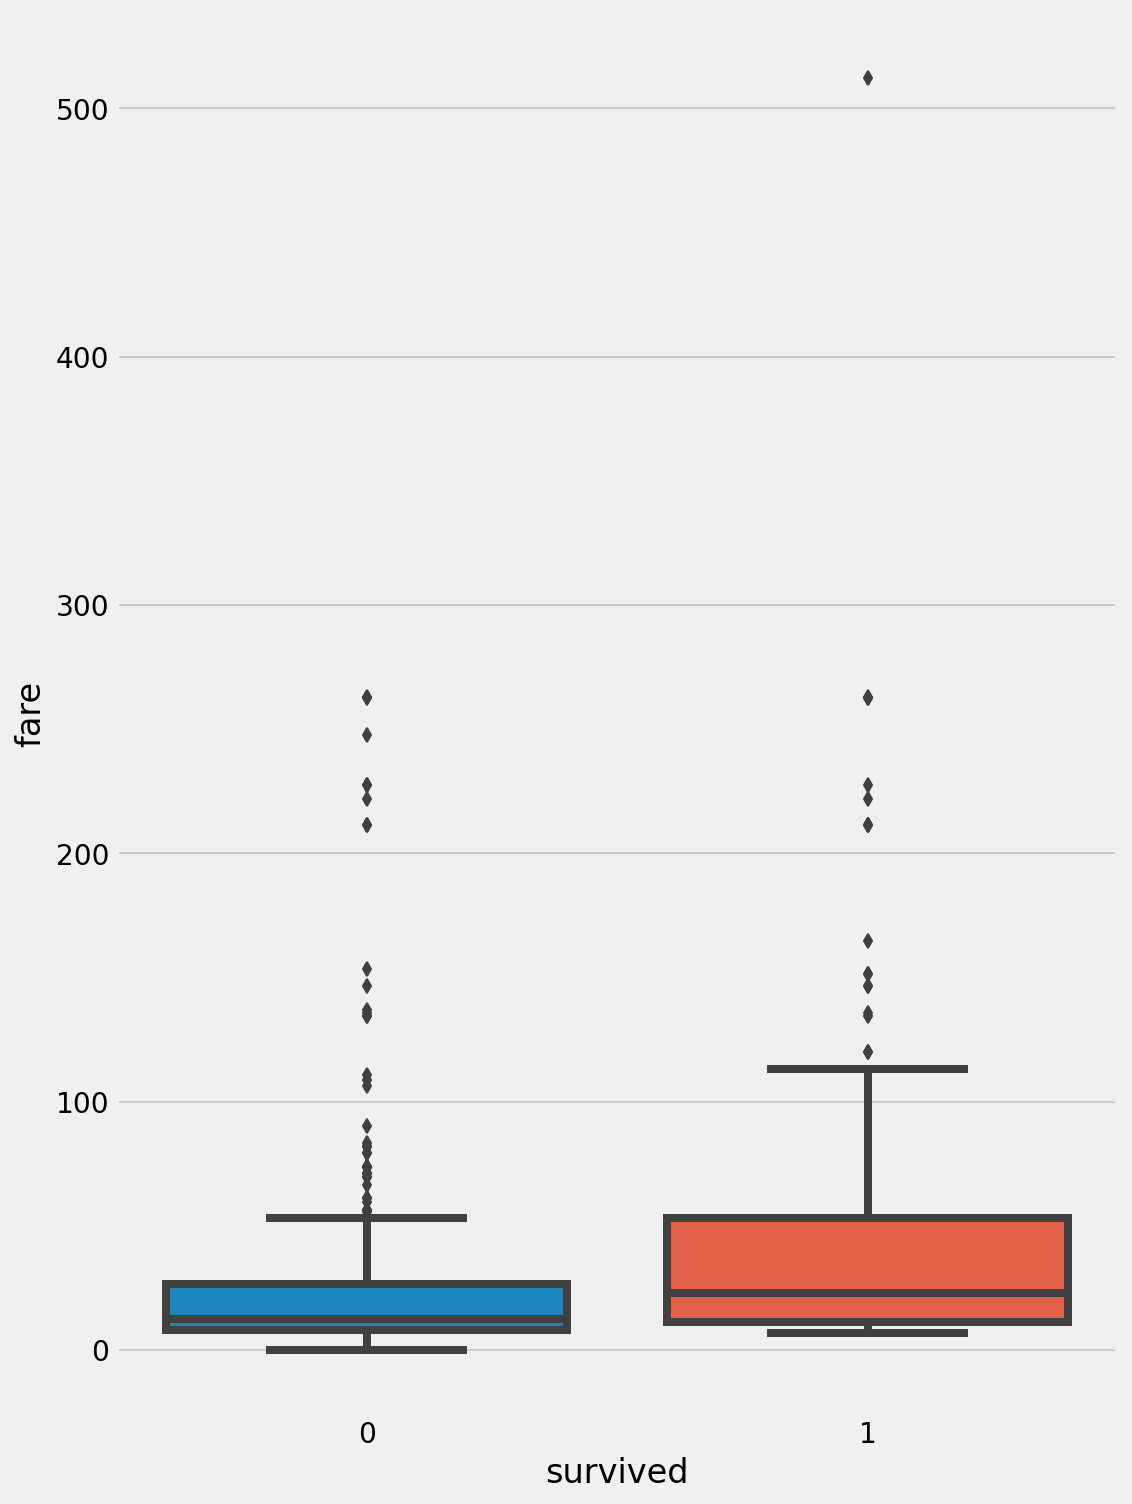

In [ ]:
fig, ax = plt.subplots(figsize = (8, 12))
sns.boxplot(x='survived', y='fare', data = data)

<AxesSubplot:xlabel='gender', ylabel='fare'>

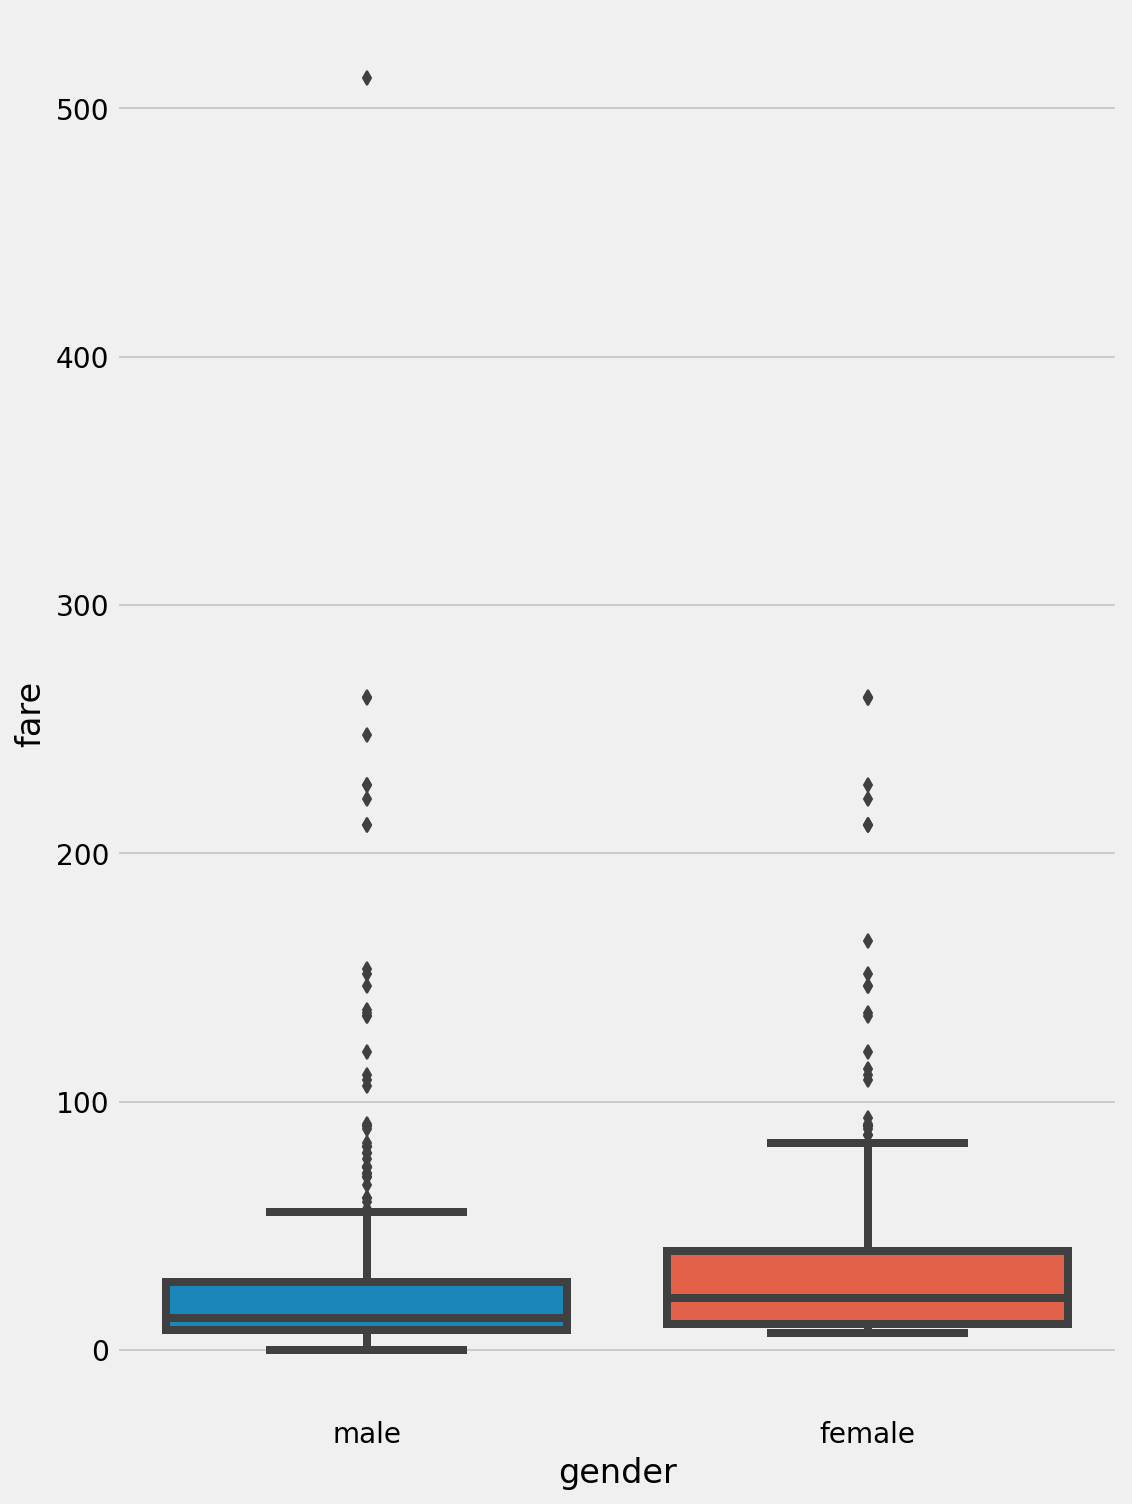

In [ ]:
fig, ax = plt.subplots(figsize = (8, 12))
sns.boxplot(x='gender', y='fare', data = data)

<AxesSubplot:xlabel='pclass', ylabel='fare'>

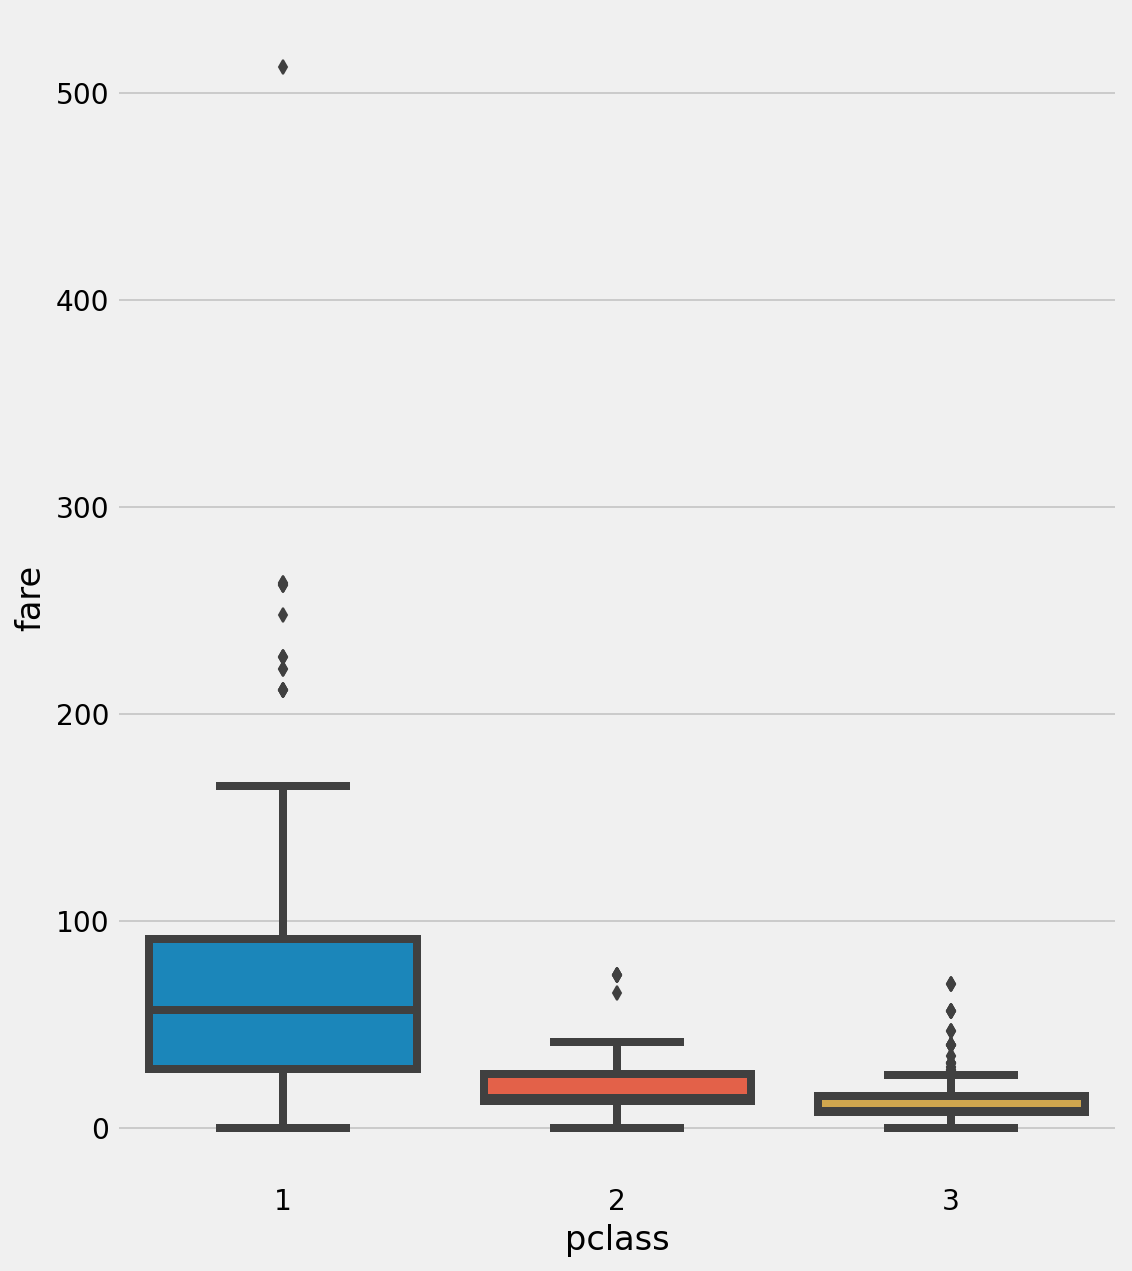

In [ ]:
fig. ax = plt.subplots(figsize = (8,10))
sns.boxplot(x = 'pclass', y='fare', data = data)

<AxesSubplot:xlabel='parch', ylabel='fare'>

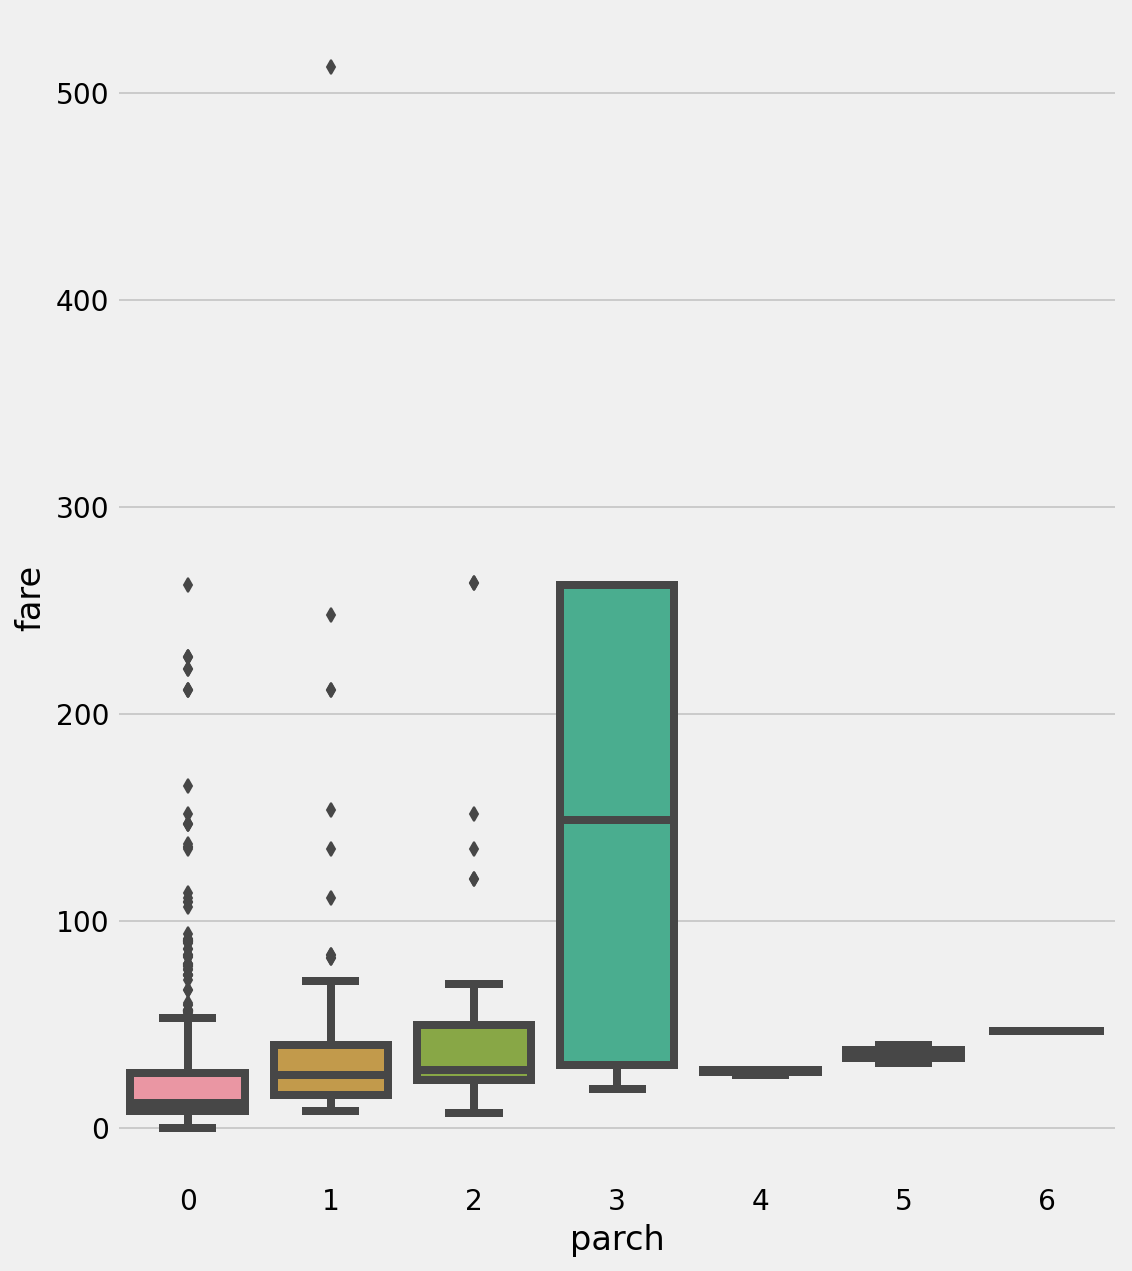

In [ ]:
fig. ax = plt.subplots(figsize = (8,10))
sns.boxplot(x = 'parch', y='fare', data = data)

<AxesSubplot:xlabel='parch', ylabel='fare'>

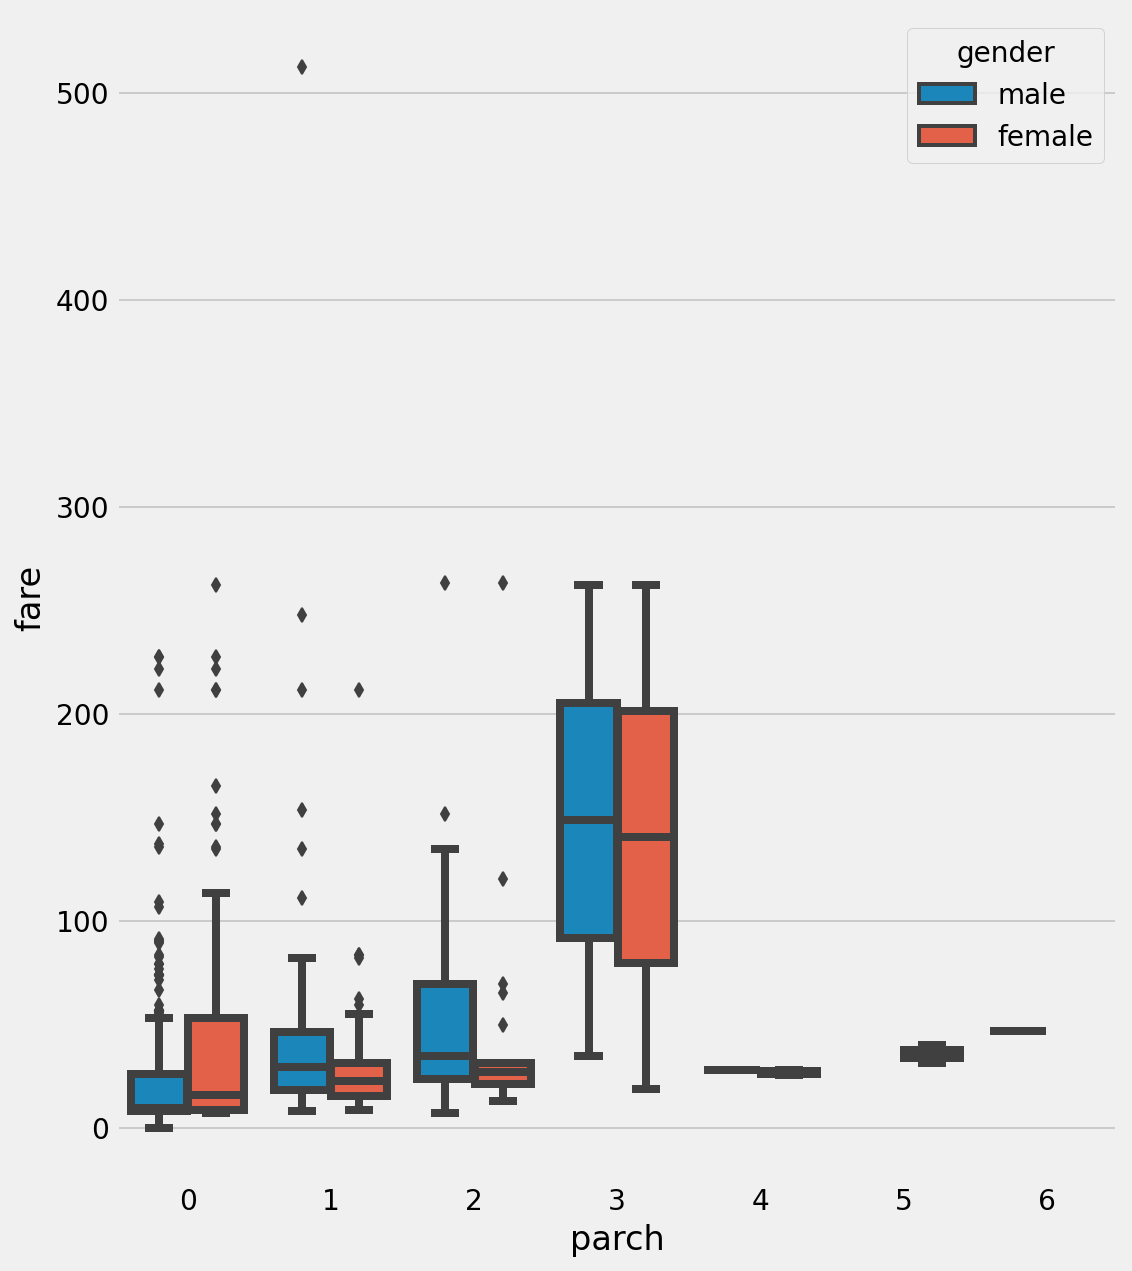

In [ ]:
fig. ax = plt.subplots(figsize = (8,10))
sns.boxplot(x = 'parch', y='fare', hue = 'gender', data = data)

<AxesSubplot:xlabel='age_', ylabel='fare'>

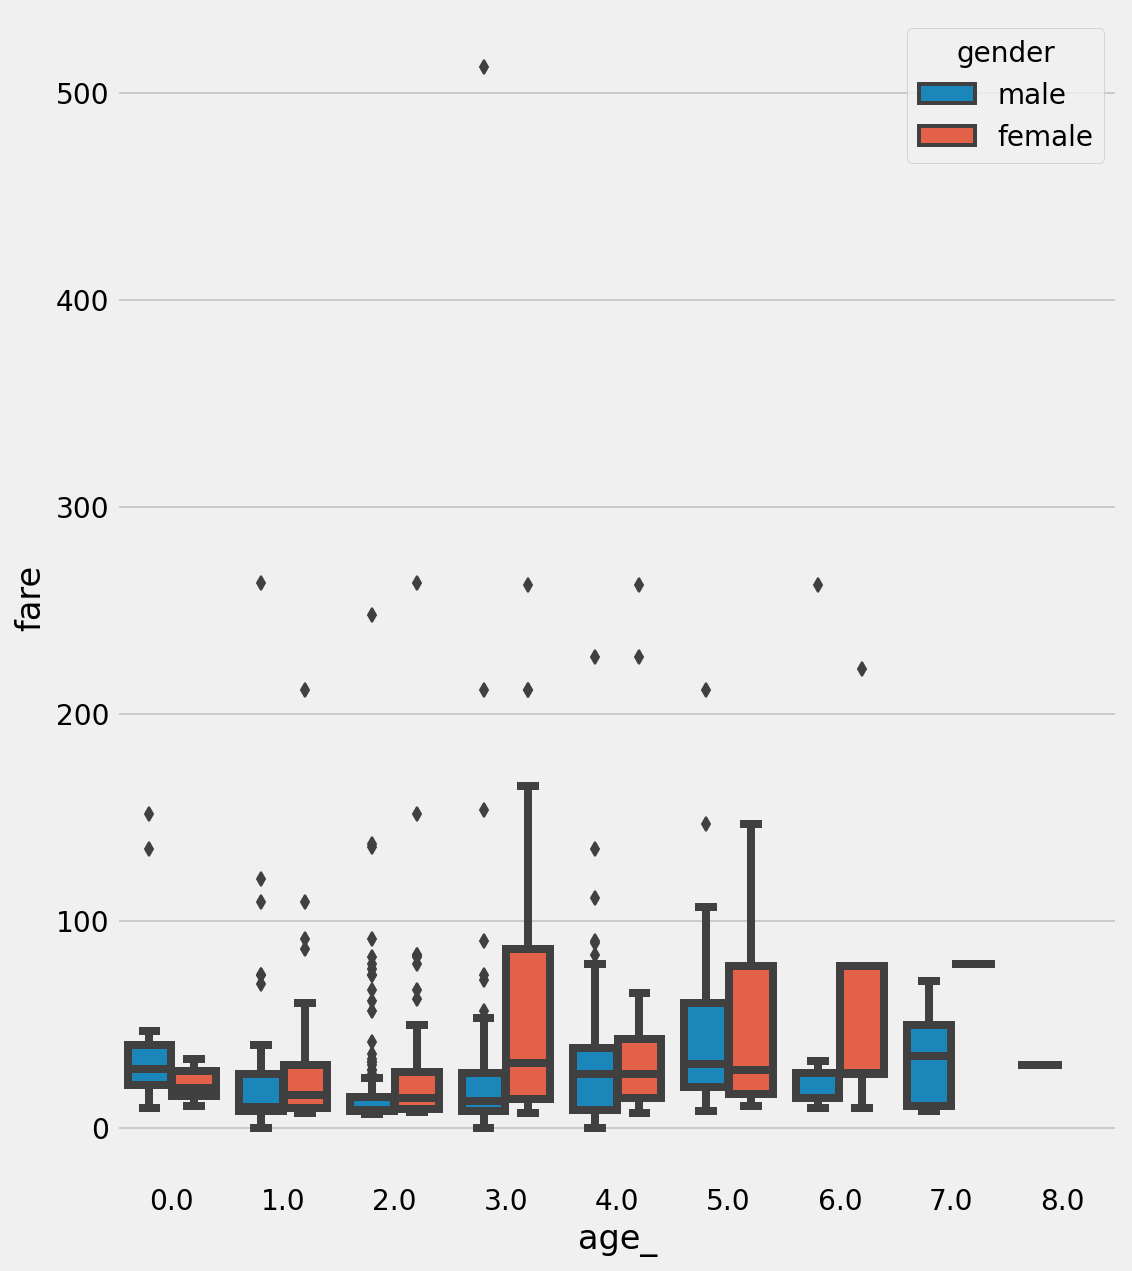

In [ ]:
fig. ax = plt.subplots(figsize = (8,10))
sns.boxplot(x = 'age_', y='fare', hue = 'gender', data = data)

<AxesSubplot:xlabel='sibsp', ylabel='fare'>

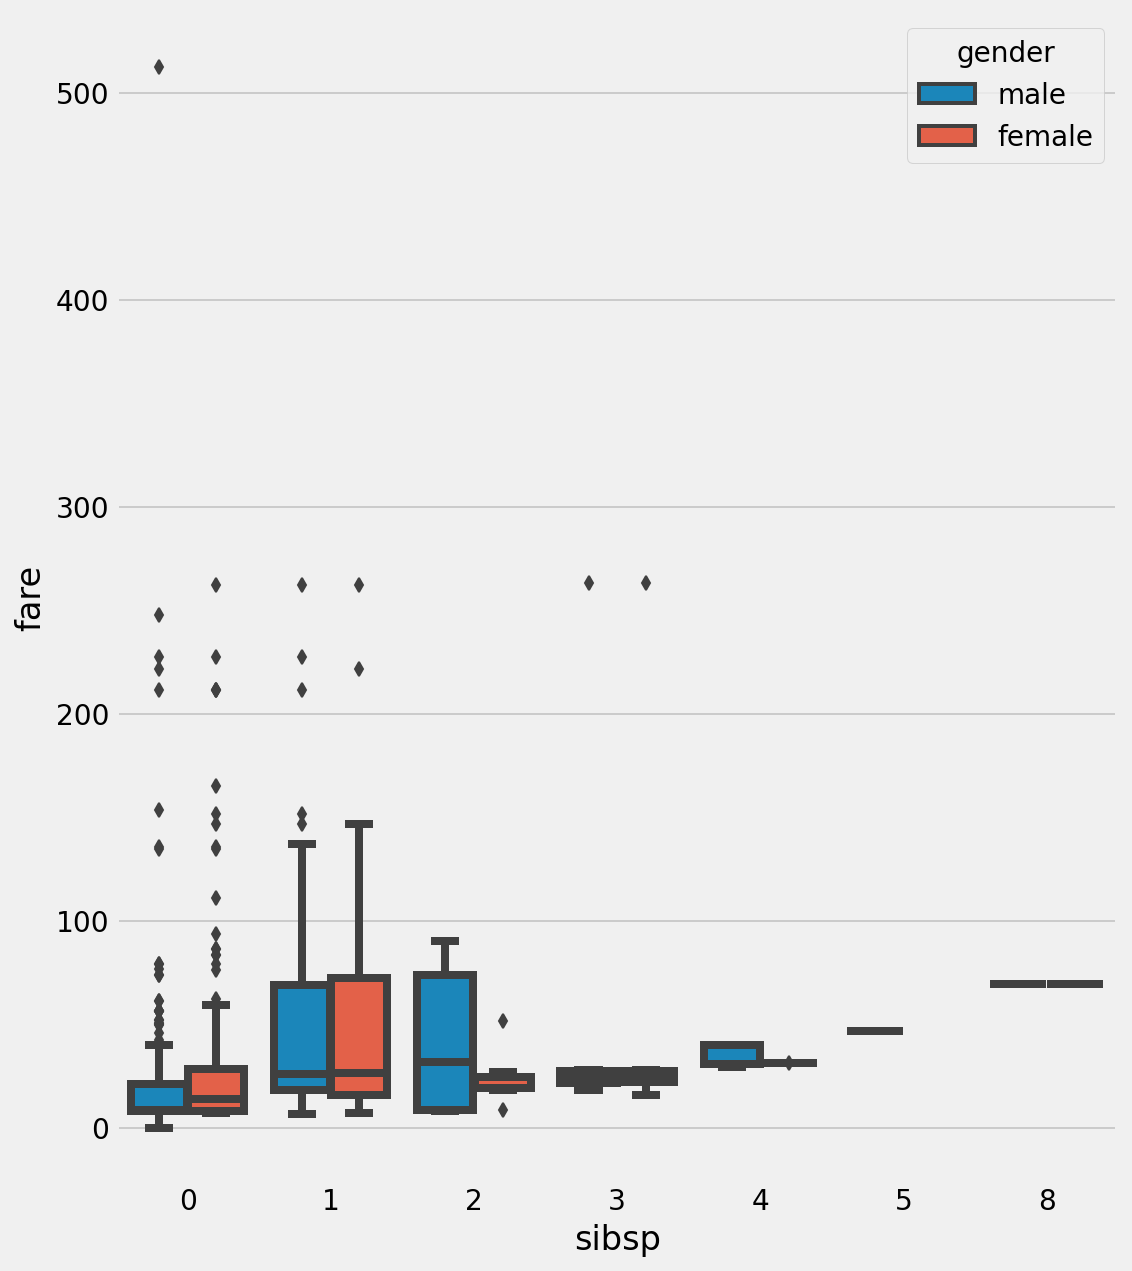

In [ ]:
fig. ax = plt.subplots(figsize = (8,10))
sns.boxplot(x = 'sibsp', y='fare', hue = 'gender', data = data)

- 전반적으로 fare가 높을수록 생존율이 높게 나타남
- 20, 40대의 죽음이 많았던 이유는 fare 와는 상관이 적은 것으로 보임

In [ ]:
df_pivot = pd.pivot_table(data,
                     index = ['age_','gender'],
                     columns = 'pclass', 
                     values = ['survived', 'fare', 'sibsp', 'parch'],
                     aggfunc = ['mean'])

df_pivot

mean                                                      \
                   fare                           parch                       
pclass                1          2          3         1         2         3   
age_ gender                                                                   
0.0  female         NaN  29.625000  19.819519       NaN  1.500000  1.375000   
     male    143.025000  25.062500  27.966925  2.000000  1.000000  1.437500   
1.0  female   93.459529  18.202311  12.835675  0.285714  0.555556  0.375000   
     male    163.966667  28.125000  14.317706  1.333333  0.100000  0.343750   
2.0  female   94.661250  20.755700  10.861314  0.600000  0.578947  0.190476   
     male     89.200700  21.990062   9.452679  0.166667  0.115385  0.027397   
3.0  female  100.326737  19.373715  14.254867  0.125000  0.461538  0.750000   
     male     75.366250  21.299096  11.758332  0.150000  0.173913  0.147059   
4.0  female  109.250700  28.666667  16.713025  0.833333  0.500000  1.500000   
     male     56.529168  17.850000  12.956408  0.090909  0.100000  0.846154   
5.0  female   64.038878  11.875000        NaN  0.111111  0.000000       NaN   
     male     75.828125  17.420833   8.050000  0.250000  0.000000  0.000000   
6.0  female  108.762500  26.000000   9.587500  0.333333  0.000000  0.000000   
     male     66.724300  14.171875        NaN  0.500000  0.000000       NaN   
7.0  female   78.850000        NaN        NaN  0.000000       NaN       NaN   
     male     51.719467  10.500000   7.775000  0.333333  0.000000  0.000000   
8.0  male     30.000000        NaN        NaN  0.000000       NaN       NaN   

                                                                         
                sibsp                      survived                      
pclass              1         2         3         1         2         3  
age_ gender                                                              
0.0  female       NaN  0.000000  1.750000       NaN  1.000000  0.687500  
     male    0.500000  1.000000  2.687500  0.500000  0.750000  0.187500  
1.0  female  0.571429  0.222222  0.562500  1.000000  1.000000  0.687500  
     male    1.666667  0.100000  0.843750  0.333333  0.000000  0.093750  
2.0  female  0.500000  0.526316  0.333333  1.000000  0.947368  0.714286  
     male    0.333333  0.423077  0.191781  0.333333  0.000000  0.109589  
3.0  female  0.458333  0.538462  0.583333  1.000000  0.923077  0.833333  
     male    0.200000  0.391304  0.264706  0.300000  0.086957  0.088235  
4.0  female  0.333333  0.666667  0.375000  1.000000  0.833333  0.250000  
     male    0.409091  0.300000  0.153846  0.227273  0.000000  0.076923  
5.0  female  0.888889  0.000000       NaN  1.000000  0.750000       NaN  
     male    0.500000  0.333333  0.000000  0.166667  0.000000  0.000000  
6.0  female  1.000000  1.000000  0.000000  1.000000  1.000000  1.000000  
     male    0.166667  0.250000       NaN  0.000000  0.250000       NaN  
7.0  female  1.000000       NaN       NaN  1.000000       NaN       NaN  
     male    0.333333  0.000000  0.000000  0.000000  0.000000  0.000000  
8.0  male    0.000000       NaN       NaN  1.000000       NaN       NaN

In [ ]:
df_pivot = pd.pivot_table(data,
                     index = ['age_','gender'],
                     columns = 'sibsp', 
                     values = ['survived'],
                     aggfunc = ['mean','count'])

df_pivot

mean                                            count        \
             survived                                         survived         
sibsp               0         1    2    3         4    5    8        0     1   
age_ gender                                                                    
0.0  female  0.750000  0.857143  1.0  0.0  0.333333  NaN  NaN      4.0   7.0   
     male    0.250000  0.750000  NaN  0.0  0.000000  0.0  NaN      4.0   8.0   
1.0  female  0.857143  1.000000  0.0  NaN  0.000000  NaN  NaN     21.0   9.0   
     male    0.066667  0.250000  0.0  0.0  0.000000  NaN  0.0     30.0   8.0   
2.0  female  0.878788  0.769231  1.0  1.0       NaN  NaN  NaN     33.0  13.0   
     male    0.098901  0.250000  0.0  0.0       NaN  NaN  NaN     91.0  12.0   
3.0  female  0.928571  0.947368  NaN  1.0       NaN  NaN  NaN     28.0  19.0   
     male    0.135593  0.200000  0.0  0.0       NaN  NaN  NaN     59.0  15.0   
4.0  female  0.636364  0.666667  NaN  NaN       NaN  NaN  NaN     11.0   9.0   
     male    0.125000  0.166667  0.0  NaN       NaN  NaN  NaN     32.0  12.0   
5.0  female  0.857143  1.000000  1.0  NaN       NaN  NaN  NaN      7.0   4.0   
     male    0.181818  0.000000  NaN  NaN       NaN  NaN  NaN     11.0   8.0   
6.0  female  1.000000  1.000000  NaN  NaN       NaN  NaN  NaN      1.0   4.0   
     male    0.125000  0.000000  NaN  NaN       NaN  NaN  NaN      8.0   2.0   
7.0  female       NaN  1.000000  NaN  NaN       NaN  NaN  NaN      NaN   1.0   
     male    0.000000  0.000000  NaN  NaN       NaN  NaN  NaN      4.0   1.0   
8.0  male    1.000000       NaN  NaN  NaN       NaN  NaN  NaN      1.0   NaN   

                                      
                                      
sibsp          2    3    4    5    8  
age_ gender                           
0.0  female  3.0  1.0  3.0  NaN  NaN  
     male    NaN  2.0  6.0  2.0  NaN  
1.0  female  1.0  NaN  1.0  NaN  NaN  
     male    3.0  1.0  2.0  NaN  1.0  
2.0  female  3.0  1.0  NaN  NaN  NaN  
     male    7.0  1.0  NaN  NaN  NaN  
3.0  female  NaN  2.0  NaN  NaN  NaN  
     male    2.0  1.0  NaN  NaN  NaN  
4.0  female  NaN  NaN  NaN  NaN  NaN  
     male    1.0  NaN  NaN  NaN  NaN  
5.0  female  2.0  NaN  NaN  NaN  NaN  
     male    NaN  NaN  NaN  NaN  NaN  
6.0  female  NaN  NaN  NaN  NaN  NaN  
     male    NaN  NaN  NaN  NaN  NaN  
7.0  female  NaN  NaN  NaN  NaN  NaN  
     male    NaN  NaN  NaN  NaN  NaN  
8.0  male    NaN  NaN  NaN  NaN  NaN

### other_cols
- 'passengerid', 'name', 'ticket', 'cabin'

In [ ]:
other_cols = ['passengerid', 'name', 'ticket', 'cabin']
data_ = pd.concat([data, train[other_cols]], axis = 1)
data_.head()

,age,gender,fare,pclass,sibsp,parch,embarked,survived,gender_pclass,gender_embarked,age_,parch_solo,parch_couple,parch_family,parch_big,passengerid,name,ticket,cabin
539,NaN,male,26.5500,1,0,0,S,0,male_1,male_S,NaN,True,False,False,False,539,"Klaber, Mr. Herman",113028,C124
339,36.0,female,135.6333,1,0,0,C,1,female_1,female_C,3.0,True,False,False,False,339,"Young, Miss. Marie Grice",PC 17760,C32
505,22.0,male,8.0500,3,0,0,S,0,male_3,male_S,2.0,True,False,False,False,505,"Davies, Mr. Evan",SC/A4 23568,NaN
492,26.0,male,8.6625,3,2,0,S,0,male_3,male_S,2.0,True,False,False,False,492,"Kink, Mr. Vincenz",315151,NaN
897,NaN,male,7.8792,3,0,0,Q,0,male_3,male_Q,NaN,True,False,False,False,897,"Linehan, Mr. Michael",330971,NaN


In [ ]:
data_[other_cols].isnull().sum()

passengerid      0
name             0
ticket           0
cabin          503
dtype: int64

In [ ]:
data_.shape

(641, 19)

## Feature Extraction Results

In [ ]:
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 11), (275, 11), (393, 11))

In [ ]:
train["age_"] = train["age"].map(lambda x: x // 10)
test["age_"] = test["age"].map(lambda x: x // 10)
ori_te["age_"] = ori_te["age"].map(lambda x: x // 10)

train['age_'].unique()

array([nan,  3.,  2.,  4.,  6.,  1.,  0.,  5.,  7.,  8.])

In [ ]:
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

train['gender_pclass'].unique()

array(['male_1', 'female_1', 'male_3', 'male_2', 'female_3', 'female_2'],
      dtype=object)

In [ ]:
train['gender_embarked'] = train.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)
test['gender_embarked'] = test.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)
ori_te['gender_embarked'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)

train['gender_embarked'].unique()

array(['male_S', 'female_C', 'male_Q', 'female_S', 'male_C', 'female_Q'],
      dtype=object)

In [ ]:
for data in [train, test, ori_te]:
  p1 = data['parch'] == 0
  data['parch_solo'] = p1

  p2 = data['parch'] == 1
  data['parch_couple'] = p2

  p3 = data['parch'] == 2 
  p4 = data['parch'] == 3
  p = p3 | p4
  data['parch_family'] = p

  p5 = data['parch'] >= 4
  data['parch_big'] = p5

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 18))

In [ ]:
train.drop('cabin', axis = 1, inplace=True)
test.drop('cabin', axis = 1, inplace=True)
ori_te.drop('cabin', axis = 1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 17), (275, 17), (393, 17))

## Missing Value

In [ ]:
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()

train.shape, test.shape, ori_te.shape

((641, 11), (275, 11), (393, 11))

In [ ]:
train.isnull().sum().sort_values(ascending = False)

cabin          503
age            118
passengerid      0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
fare             0
embarked         0
dtype: int64

In [ ]:
test.isnull().sum().sort_values(ascending = False)

cabin          215
age             62
embarked         1
passengerid      0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
fare             0
dtype: int64

In [ ]:
ori_te.isnull().sum().sort_values(ascending = False)

cabin          296
age             83
fare             1
embarked         1
passengerid      0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
dtype: int64

In [ ]:
train.drop('cabin', axis = 1, inplace=True)
test.drop('cabin', axis = 1, inplace=True)
ori_te.drop('cabin', axis = 1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

In [ ]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def __get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in __get_cols_cleaning(pd_list):  # for col in cols_cleaning:
    for i, df in enumerate(pd_list, start=1): 
      
      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]   
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index 
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling
        
        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)
      
      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')


In [ ]:
add_cols_cleaning(train, test, ori_te)

cols_cleaning: ['embarked', 'fare', 'age']
p_train: 0 / p_test: 0 / p_ori_te: 0


In [ ]:
train.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'sibsp', 'parch', 'ticket',
       'embarked', 'fare_cleaning', 'age_cleaning'],
      dtype='object')

In [ ]:
cols = ['passengerid', 'pclass', 'name', 'gender', 'sibsp', 'parch', 'ticket',
       'embarked', 'fare', 'age']

for df in [train, test, ori_te]:
  df.columns = cols

In [ ]:
train.head()

,passengerid,pclass,name,gender,sibsp,parch,ticket,embarked,fare,age
539,539,1,"Klaber, Mr. Herman",male,0,0,113028,S,26.5500,36.0
339,339,1,"Young, Miss. Marie Grice",female,0,0,PC 17760,C,135.6333,36.0
505,505,3,"Davies, Mr. Evan",male,0,0,SC/A4 23568,S,8.0500,22.0
492,492,3,"Kink, Mr. Vincenz",male,2,0,315151,S,8.6625,26.0
897,897,3,"Linehan, Mr. Michael",male,0,0,330971,Q,7.8792,41.0


In [ ]:
test.head()

,passengerid,pclass,name,gender,sibsp,parch,ticket,embarked,fare,age
774,774,1,"Frauenthal, Mr. Isaac Gerald",male,1,0,17765,C,27.7208,43.0
583,583,3,"Sage, Mr. Douglas Bullen",male,8,2,CA. 2343,S,69.5500,57.0
112,112,1,"Ryerson, Miss. Emily Borie",female,2,2,PC 17608,C,262.3750,18.0
118,118,3,"Sundman, Mr. Johan Julian",male,0,0,STON/O 2. 3101269,S,7.9250,44.0
911,911,3,"Thomas, Mr. Charles P",male,1,0,2621,C,6.4375,32.0


In [ ]:
ori_te.head()

,passengerid,pclass,name,gender,sibsp,parch,ticket,embarked,fare,age
0,916,3,"McGowan, Miss. Anna ""Annie""",female,0,0,330923,Q,8.0292,15.0
1,917,2,"Pinsky, Mrs. (Rosa)",female,0,0,234604,S,13.0000,32.0
2,918,3,"McCarthy, Miss. Catherine Katie""""",female,0,0,383123,Q,7.7500,33.0
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",male,0,0,SOTON/O.Q. 3101314,S,7.2500,40.0
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,1,1,36928,S,164.8667,45.0


In [ ]:
train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 10))

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

## Add Features

In [ ]:
train["age_"] = train["age"].map(lambda x: x // 10)
test["age_"] = test["age"].map(lambda x: x // 10)
ori_te["age_"] = ori_te["age"].map(lambda x: x // 10)

train['age_'].unique()

array([3., 2., 4., 6., 1., 0., 5., 7., 8.])

In [ ]:
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

train['gender_pclass'].unique()

array(['male_1', 'female_1', 'male_3', 'male_2', 'female_3', 'female_2'],
      dtype=object)

In [ ]:
train['gender_embarked'] = train.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)
test['gender_embarked'] = test.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)
ori_te['gender_embarked'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['embarked']), axis=1)

train['gender_embarked'].unique()

array(['male_S', 'female_C', 'male_Q', 'female_S', 'male_C', 'female_Q'],
      dtype=object)

In [ ]:
for data in [train, test, ori_te]:
  p1 = data['parch'] == 0
  data['parch_solo'] = p1

  p2 = data['parch'] == 1
  data['parch_couple'] = p2

  p3 = data['parch'] == 2 
  p4 = data['parch'] == 3
  p = p3 | p4
  data['parch_family'] = p

  p5 = data['parch'] >= 4
  data['parch_big'] = p5

train.shape, test.shape, ori_te.shape

((641, 17), (275, 17), (393, 17))

## Scaling

In [ ]:
train.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'sibsp', 'parch', 'ticket',
       'embarked', 'fare', 'age', 'age_', 'gender_pclass', 'gender_embarked',
       'parch_solo', 'parch_couple', 'parch_family', 'parch_big'],
      dtype='object')

In [ ]:
train.select_dtypes(include = np.number)

,passengerid,pclass,sibsp,parch,fare,age,age_
539,539,1,0,0,26.5500,36.0,3.0
339,339,1,0,0,135.6333,36.0,3.0
505,505,3,0,0,8.0500,22.0,2.0
492,492,3,2,0,8.6625,26.0,2.0
897,897,3,0,0,7.8792,41.0,4.0
...,...,...,...,...,...,...,...
538,538,3,0,0,9.3250,24.0,2.0
761,761,3,1,0,14.4542,15.0,1.0
879,879,3,0,2,24.1500,10.0,1.0
214,214,1,0,0,79.2000,24.0,2.0


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaling_cols = ['pclass', 'sibsp', 'parch', 'age_', 'fare', 'age']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled, 
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = scaled_dfs[0]
test = scaled_dfs[1]
ori_te = scaled_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0 / 0 / 0


((641, 17), (275, 17), (393, 17))

In [ ]:
train.head()

,passengerid,gender,embarked,gender_pclass,name,parch_big,ticket,parch_family,parch_solo,gender_embarked,parch_couple,pclass,sibsp,parch,age_,fare,age
0,539,male,S,male_1,"Klaber, Mr. Herman",False,113028,False,True,male_S,False,-1.519560,-0.496392,-0.437574,0.302153,-0.114641,0.428847
1,339,female,C,female_1,"Young, Miss. Marie Grice",False,PC 17760,False,True,female_C,False,-1.519560,-0.496392,-0.437574,0.302153,2.204701,0.428847
2,505,male,S,male_3,"Davies, Mr. Evan",False,SC/A4 23568,False,True,male_S,False,0.870717,-0.496392,-0.437574,-0.361135,-0.507990,-0.526524
3,492,male,S,male_3,"Kink, Mr. Vincenz",False,315151,False,True,male_S,False,0.870717,1.517451,-0.437574,-0.361135,-0.494967,-0.253561
4,897,male,Q,male_3,"Linehan, Mr. Michael",False,330971,False,True,male_Q,False,0.870717,-0.496392,-0.437574,0.965440,-0.511622,0.770051


## Encoding

In [ ]:
train.columns

Index(['passengerid', 'gender', 'embarked', 'gender_pclass', 'name',
       'parch_big', 'ticket', 'parch_family', 'parch_solo', 'gender_embarked',
       'parch_couple', 'pclass', 'sibsp', 'parch', 'age_', 'fare', 'age'],
      dtype='object')

In [ ]:
train.select_dtypes(exclude=np.number)

,gender,embarked,gender_pclass,name,parch_big,ticket,parch_family,parch_solo,gender_embarked,parch_couple
0,male,S,male_1,"Klaber, Mr. Herman",False,113028,False,True,male_S,False
1,female,C,female_1,"Young, Miss. Marie Grice",False,PC 17760,False,True,female_C,False
2,male,S,male_3,"Davies, Mr. Evan",False,SC/A4 23568,False,True,male_S,False
3,male,S,male_3,"Kink, Mr. Vincenz",False,315151,False,True,male_S,False
4,male,Q,male_3,"Linehan, Mr. Michael",False,330971,False,True,male_Q,False
...,...,...,...,...,...,...,...,...,...,...
636,male,S,male_3,"Salander, Mr. Karl Johan",False,7266,False,True,male_S,False
637,female,C,female_3,"Yasbeck, Mrs. Antoni (Selini Alexander)",False,2659,False,True,female_C,False
638,female,S,female_3,"Van Impe, Miss. Catharina",False,345773,True,False,female_S,False
639,male,C,male_1,"Giglio, Mr. Victor",False,PC 17593,False,True,male_C,False


In [ ]:
for df in [train, test, ori_te]:
  df['parch_big'] = df['parch_big'].astype("int32")
  df['parch_family'] = df['parch_family'].astype("int32")
  df['parch_solo'] = df['parch_solo'].astype("int32")
  df['parch_couple'] = df['parch_couple'].astype("int32")

In [ ]:
encoding_cols = ['gender', 'embarked', 'gender_pclass', 'gender_embarked']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc_cols = ['gender', 'embarked', 'gender_pclass', 'gender_embarked']
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder() 
enc_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(), 
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = enc_dfs[0]
test = enc_dfs[1]
ori_te = enc_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

len_enc_cols: 4
0 / 0 / 0


((641, 30), (275, 30), (393, 30))

## Modeling

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [ ]:
train.columns

Index(['passengerid', 'parch', 'sibsp', 'name', 'age', 'parch_big', 'ticket',
       'fare', 'parch_family', 'parch_solo', 'pclass', 'parch_couple', 'age_',
       'gender_female', 'gender_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'gender_pclass_female_1', 'gender_pclass_female_2',
       'gender_pclass_female_3', 'gender_pclass_male_1',
       'gender_pclass_male_2', 'gender_pclass_male_3',
       'gender_embarked_female_C', 'gender_embarked_female_Q',
       'gender_embarked_female_S', 'gender_embarked_male_C',
       'gender_embarked_male_Q', 'gender_embarked_male_S'],
      dtype='object')

In [ ]:
cols = ['parch', 'sibsp', 'age', 'parch_big',
       'fare', 'parch_family', 'parch_solo', 'pclass', 'parch_couple', 'age_',
       'gender_female', 'gender_male', 'embarked_C', 'embarked_Q',
       'embarked_S', 'gender_pclass_female_1', 'gender_pclass_female_2',
       'gender_pclass_female_3', 'gender_pclass_male_1',
       'gender_pclass_male_2', 'gender_pclass_male_3',
       'gender_embarked_female_C', 'gender_embarked_female_Q',
       'gender_embarked_female_S', 'gender_embarked_male_C',
       'gender_embarked_male_Q', 'gender_embarked_male_S']

X_tr = train[cols]
X_te = test[cols]
ori_te = ori_te[cols]

X_tr.shape, X_te.shape, ori_te.shape

((641, 27), (275, 27), (393, 27))

In [ ]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((641, 27), (275, 27), (641,), (275,))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
modelV1 = DecisionTreeClassifier(random_state=args.random_state)

modelV1.fit(X_tr, y_tr)

DecisionTreeClassifier(random_state=42)

## Evaluation

In [ ]:
score_tr = modelV1.score(X_tr, y_tr)
score_te = modelV1.score(X_te, y_te) 

score_tr, score_te

(0.9906396255850234, 0.7527272727272727)

In [ ]:
from sklearn.metrics import roc_curve, auc 

In [ ]:
y_pred = modelV1.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.7579847053531265


In [ ]:
ori_te_pred = modelV1.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

In [ ]:
df_feature_importances = pd.DataFrame(modelV1.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(27, 2)


,index,0
0,gender_female,0.531190
1,fare,0.169875
2,age,0.162931
3,age_,0.031489
4,pclass,0.028754
5,sibsp,0.022331
6,parch_couple,0.007928
7,parch,0.006096
8,embarked_Q,0.005894
9,gender_embarked_male_Q,0.005644


In [ ]:
args.results.append(
    {
        'model': 'modelV1',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0220'
    }
)

In [ ]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV0,0.99064,0.792727,0.788715,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",11,"[gender_male, age_random, fare, sibsp, pclass_...",0227
1,modelV1,0.99064,0.752727,0.757985,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",27,"[gender_female, fare, age, age_, pclass, sibsp...",0220


# Submission

In [ ]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt
0,modelV0,0.99064,0.792727,0.788715,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",11,"[gender_male, age_random, fare, sibsp, pclass_...",0227
1,modelV1,0.99064,0.752727,0.757985,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",27,"[gender_female, fare, age, age_, pclass, sibsp...",0220


In [ ]:
submission = pd.read_csv(args.submission_csv)
submission.head()

,passengerid,survived
0,916,1.0
1,917,1.0
2,918,1.0
3,919,0.0
4,920,1.0


In [ ]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0]
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,1.0
1,917,1.0
2,918,1.0
3,919,0.0
4,920,1.0
5,921,1.0
6,922,0.0
7,923,0.0
8,924,0.0
9,925,0.0


In [ ]:
submission.to_csv(args.submission_csv, header=True, index=False)

# Save Results

In [ ]:
args.save_results

'/content/gdrive/My Drive/titanic_kaggle/data/model_results.json'

In [ ]:
df_results.columns

Index(['model', 'score_tr', 'score_te', 'auc_te', 'ori_te_pred',
       'len_features', 'feaute_importances', 'create_dt'],
      dtype='object')

In [ ]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True) 

In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
df_results.head()

,model,score_tr,score_te,auc_te,len_features,feaute_importances,create_dt
0,modelV0,0.99064,0.792727,0.788715,11,"[gender_male, age_random, fare, sibsp, pclass_...",0227
1,modelV1,0.99064,0.752727,0.757985,27,"[gender_female, fare, age, age_, pclass, sibsp...",0220


In [ ]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

load_results

[{'model': 'modelV0',
  'score_tr': 0.9906396256,
  'score_te': 0.7927272727,
  'auc_te': 0.7887145749,
  'len_features': 11,
  'feaute_importances': ['gender_male',
   'age_random',
   'fare',
   'sibsp',
   'pclass_3.0',
   'parch',
   'embarked_C',
   'pclass_2.0',
   'embarked_Q',
   'embarked_S',
   'pclass_1.0'],
  'create_dt': '0227'},
 {'model': 'modelV1',
  'score_tr': 0.9906396256,
  'score_te': 0.7527272727,
  'auc_te': 0.7579847054,
  'len_features': 27,
  'feaute_importances': ['gender_female',
   'fare',
   'age',
   'age_',
   'pclass',
   'sibsp',
   'parch_couple',
   'parch',
   'embarked_Q',
   'gender_embarked_male_Q',
   'gender_embarked_male_C',
   'gender_embarked_female_S',
   'gender_pclass_male_3',
   'embarked_S',
   'gender_pclass_male_2',
   'gender_embarked_male_S',
   'parch_big',
   'embarked_C',
   'gender_embarked_female_Q',
   'gender_embarked_female_C',
   'parch_solo',
   'parch_family',
   'gender_pclass_female_3',
   'gender_pclass_female_2',
   '